In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

import numpy as np
from scipy.io import loadmat
import sys
import src.config as cfg
import src.fitting as fit
import src.recon as recon
import visionloader as vl
import matplotlib.pyplot as plt
from scipy import stats
import cv2
import jax
import jax.numpy as jnp
from stim_algos import GTDExperiment, DictionaryEntry
import estim_utils.triplet as triplet

%load_ext autoreload
%autoreload 2

In [2]:
FRAME_TIME = 1.5
STIM_TIME = 5e-5
REFRACTORY_DELAY = 200
GUARD_TIME = 0

In [3]:
def calculate_sig_stixels(sta, num_frames=9, alpha=1/10000, color_channels=None):
    """
    Sam Cooler sig stix implementation.

    Parameters:
        sta: STA of size t,y,x,c, with zero mean!
        num_frames: frames to use in noise calculation
        alpha: significance level
        color_channels: color channels to use
    Returns: tuple of booleans denoting the sig stix and the p values.
    
    Flips the STA and re-orders dims, but changes it back (doesn't mutate).

    """
    # Rearrange the dims and flip.
    sta = np.flip(np.moveaxis(sta,0,-2),axis=-2)

    if color_channels is None:
        color_channels = (0,1,2)

    early_frames = np.mean(sta[...,0:num_frames,color_channels], 3) 
    #std_this_cell = stats.median_absolute_deviation(early_frames.flatten())
    std_this_cell = stats.median_abs_deviation(early_frames.flatten())

    # Mean over color, square, sum over time
    input_frame = np.sum(np.power(np.mean(sta[...,-(num_frames+1):-1,
                               color_channels],3) / std_this_cell, 2), 2)

    # Chi squares survival = 1 - CDF
    pvalues = stats.chi2(df=num_frames).sf(input_frame) + np.finfo(float).eps 
    pvalues *= (sta.shape[0] * sta.shape[1]) # bonferroni correction

    # Put it back in order.
    sta = np.flip(np.moveaxis(sta,-2,0),axis=0)

    return pvalues < alpha, pvalues

## Get the gsorted cells

In [4]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-18-0"
wnoise = "kilosort_data000/data000"
estim_neg = "data001"
outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)

vcd = vl.load_vision_data(f'/Volumes/Analysis/{dataset}/{wnoise}',
                          os.path.basename(wnoise),
                          include_ei=True,
                          include_neurons=True,
                          include_params=True,
                          include_sta=True,
                          include_noise=True)

parameters = loadmat(os.path.join(outpath, 'parameters.mat'))
cells = parameters['cells'].flatten()
gsorted_cells = parameters['gsorted_cells'].flatten()

gsorted_cells_new = []
for i in range(len(gsorted_cells)):
    if 'parasol' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
        gsorted_cells_new.append(gsorted_cells[i])
    # if 'midget' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
    #     gsorted_cells_new.append(gsorted_cells[i])

gsorted_cells = np.array(gsorted_cells_new)
cells_to_use = cells[gsorted_cells]

## Constants

In [5]:
RESAMPLE_X = 320 # 80
RESAMPLE_Y = 160 # 40
ALPHA = 1/100000

In [6]:
stas = []
stas_fit = []
remove_cells = []

for cell in cells_to_use:
    sta = vcd.get_sta_for_cell(cell) 
    sta = np.stack([sta.red,sta.green,sta.blue])
    sta = np.swapaxes(sta,0,-1)
    
    # Resample the STA
    sta = np.asarray([cv2.resize(sta[i,...],(RESAMPLE_X,RESAMPLE_Y),interpolation=cv2.INTER_CUBIC)
           for i in range(sta.shape[0])
          ])
    sig_stix = calculate_sig_stixels(np.flip(sta,axis=0) - np.mean(sta),alpha=ALPHA)
    sta -= np.mean(sta)
    mask = sig_stix[0].astype(int)
    tc = np.sum(sta * mask[None,...,None],axis=(-1,-2,-3))
    sta = np.mean(sta[np.argmax(np.abs(tc)),...],axis=-1)
    
    # Fit 2d Gaussian.
    popt, pcov = fit.fit_gaussian2d(sta[...,None],np.argwhere(sig_stix[0]))
    
    if np.inf in np.absolute(pcov).flatten():
        remove_cells.append(cell)
        continue
        
    orig_n_pixels_x = sta.shape[1]
    orig_n_pixels_y = sta.shape[0]
    x = np.linspace(0,orig_n_pixels_x-1,RESAMPLE_X)
    y = np.linspace(0,orig_n_pixels_y-1,RESAMPLE_Y)
    xx,yy = np.meshgrid(x,y)
    out = fit.gaussian2d((xx,yy),*popt)
    out = recon.mask_gaussian_filter(out,popt,xx,yy,4)
    stas_fit.append(out)
    stas.append(sta)
    
stas = np.asarray(stas)
stas_fit = np.asarray(stas_fit)

In [7]:
remove_cell_inds = np.searchsorted(cells_to_use, np.array(remove_cells))
gsorted_cells = np.setdiff1d(gsorted_cells, gsorted_cells[remove_cell_inds])
cells_to_use = np.setdiff1d(cells_to_use, np.array(remove_cells))

## Scale the STAs

In [8]:
try:
    encoding_filters = np.load(f'encoding_filters_{dataset}.npy')
except:
    encoding_filters = recon.get_encoding_filters_pooled(stas_fit,
                                                inds=[np.arange(0,stas.shape[0])],
                                                firing_rates=[3],
                                                stixels=cfg.STIXEL_SIZES)
    np.save(f'encoding_filters_{dataset}.npy', encoding_filters)

## Compute reconstruction filters

In [9]:
try:
    decoding_filters = np.load(f'decoding_filters_{dataset}.npy')
except:
    decoding_filters = recon.learn_recon_filters_pooled(encoding_filters.reshape(-1,RESAMPLE_Y,RESAMPLE_X))
    np.save(f'decoding_filters_{dataset}.npy', decoding_filters)

In [10]:
# for i in range(decoding_filters.shape[0]):
#     plt.figure()
#     plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
#     plt.show()

## Do greedy ..

In [11]:
mask = (np.sum(np.abs(encoding_filters),axis=0)!=0).astype(int)
sig_stix = np.argwhere(mask).flatten()

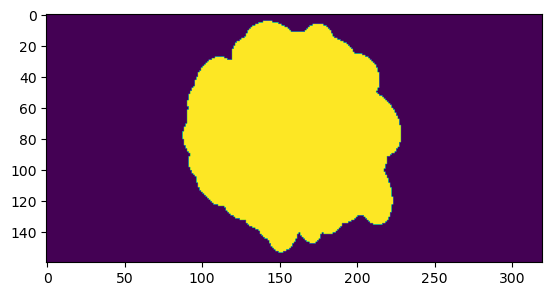

In [12]:
plt.imshow(mask.reshape(160,320))

In [13]:
dict_data_1elec = loadmat(f'estim_dictionary_1elec_{dataset}.mat', squeeze_me=True, 
                          struct_as_record=False)
dictionary_matrix = dict_data_1elec['dictionary_matrix']
dictionary_matrix = dictionary_matrix[:, np.setdiff1d(np.arange(dictionary_matrix.shape[1], dtype=int),
                                                      np.array(remove_cell_inds))]
electrodes_amplitudes = dict_data_1elec['EA']

In [14]:
dictionary_matrix.shape, decoding_filters.shape

((4025, 214), (214, 51200))

In [15]:
decoder = decoding_filters.reshape(decoding_filters.shape[0], 1, 160, 320)

dictionary_info = []
for entry in range(dictionary_matrix.shape[0]):
    dictionary_info.append(
        DictionaryEntry(
           electrodes= [electrodes_amplitudes[entry, 0]],
           pulses_indices=[electrodes_amplitudes[entry, 1]],
           num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
           )
        )

In [ ]:
NUM_REPEATS = 100
error_map_avg = np.zeros(decoding_filters.shape[1])
signed_error_map_avg = np.zeros(decoding_filters.shape[1])

for i in range(NUM_REPEATS):
    print(f'Repeat {i+1}')
    
    visual_stimulus = recon.get_random_stimuli_jitter(1, 32, RESAMPLE_X, RESAMPLE_Y)
    visual_stimulus = visual_stimulus.reshape(1, 160, 320)

    # plt.figure()
    # plt.imshow(visual_stimulus[0] * mask.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    experiment_without_sm = GTDExperiment(
        dictionary=dictionary_matrix, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm = experiment_without_sm.run()
    masked_expt = experiment_without_sm.reconstruction[0].flatten() * mask

    # plt.figure()
    # plt.imshow(masked_expt.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    masked_stimulus = jnp.array(visual_stimulus[0].reshape(160*320, 1).ravel() * mask)
    masked_decoder = jnp.array((decoding_filters.T * mask[:, None]))

    losses, x = recon.get_optimal_recon_jax(masked_decoder, masked_stimulus, 
                                            jnp.array(np.absolute(np.random.normal(size=decoding_filters.shape[0]))),
                                            step_size=2, n_steps=1000, verbose=False, obj_tol=1e-5)

    # plt.figure()
    # plt.plot(losses)
    # plt.show()

    masked_opt = (decoding_filters.T @ x) * mask
    # plt.figure()
    # plt.imshow(masked_opt.reshape(160,320),cmap='gray', vmin=-1, vmax=1)
    # plt.xlim([70,250])
    # plt.show()

    error_map = (masked_opt - masked_expt)**2 / np.linalg.norm(visual_stimulus[0].ravel() * mask)**2
    signed_error_map = masked_opt - masked_expt

    error_map_avg += error_map
    signed_error_map_avg += signed_error_map

    # input()

error_map_avg = error_map_avg / NUM_REPEATS
signed_error_map_avg = signed_error_map_avg / NUM_REPEATS

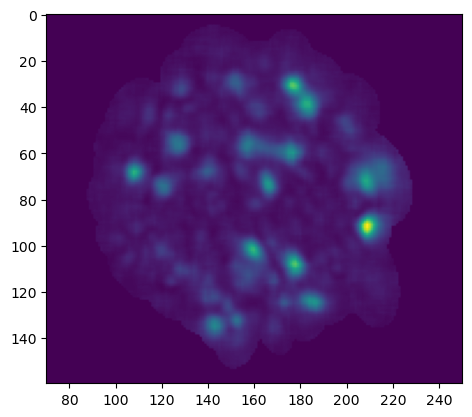

In [17]:
plt.figure()
plt.imshow(error_map_avg.reshape(160, 320))
plt.xlim([70,250])
plt.show()

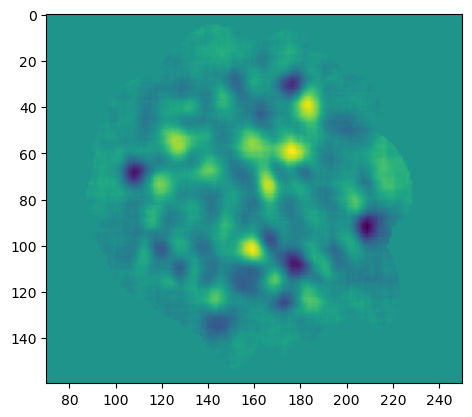

In [18]:
plt.figure()
plt.imshow(signed_error_map_avg.reshape(160, 320))
plt.xlim([70,250])
plt.show()

In [ ]:
np.save(f'error_map_avg_{dataset}.npy', error_map_avg)
np.save(f'signed_error_map_avg_{dataset}.npy', signed_error_map_avg)

In [16]:
error_map_avg = np.load(f'error_map_avg_{dataset}.npy')
signed_error_map_avg = np.load(f'signed_error_map_avg_{dataset}.npy')

Target 1

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims


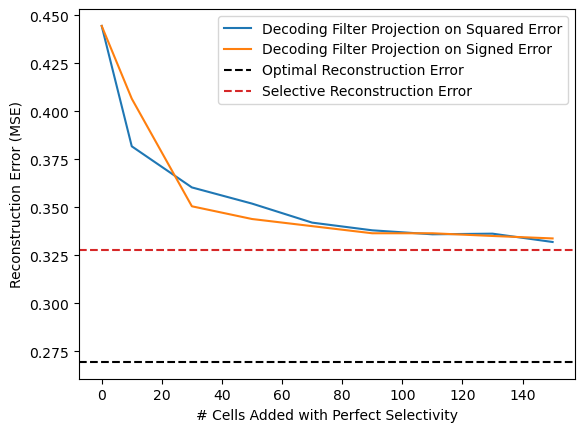

Target 2

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims


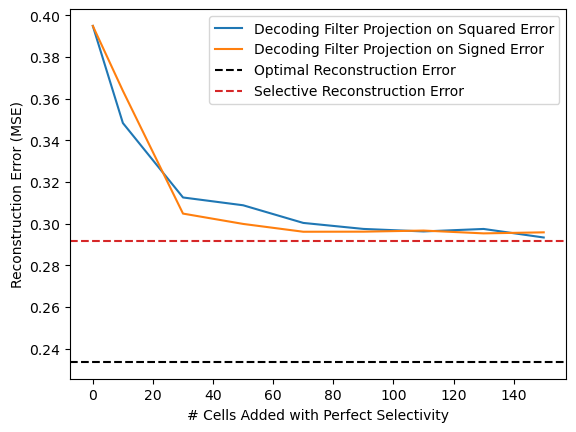

Target 3

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims


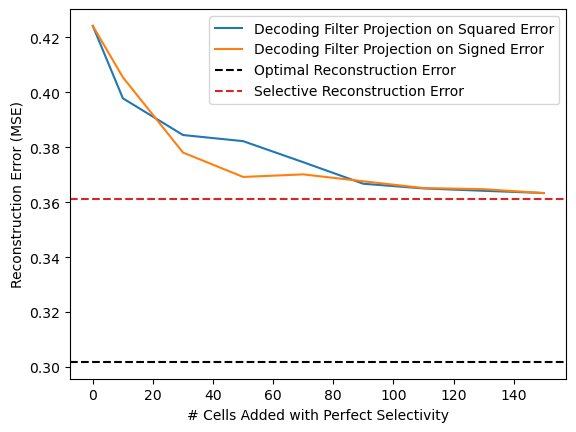

Target 4

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims


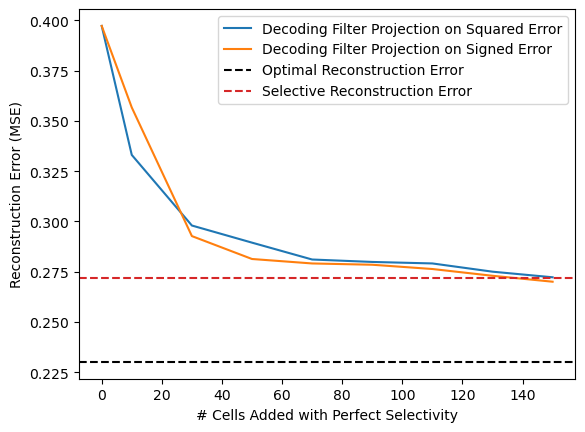

Target 5

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


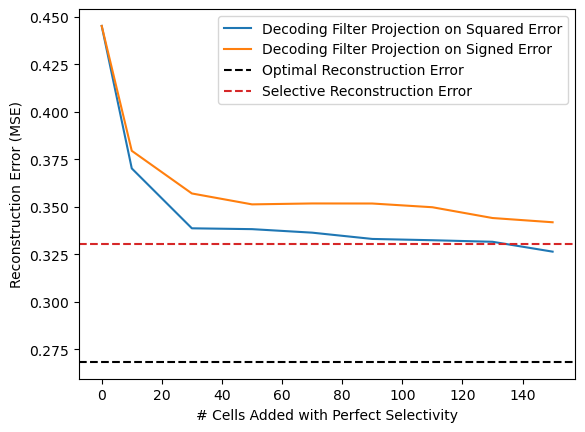

Target 6

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims


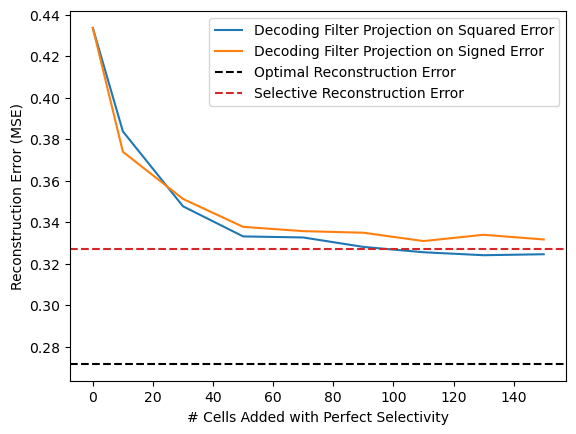

Target 7

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


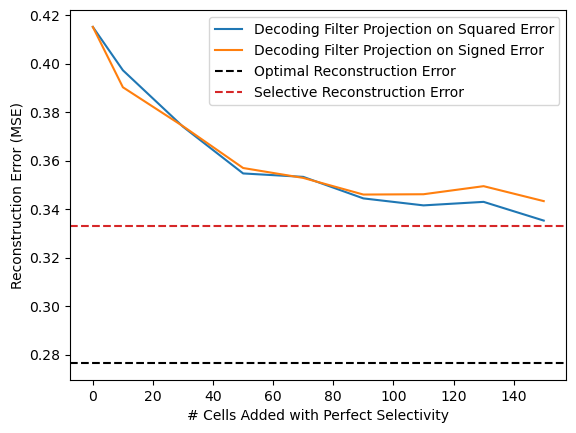

Target 8

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


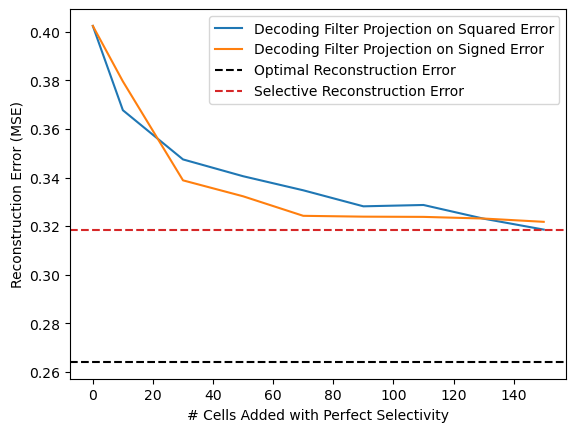

Target 9

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims


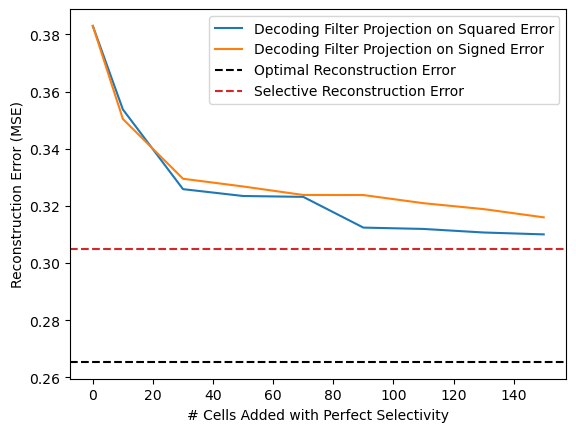

Target 10

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


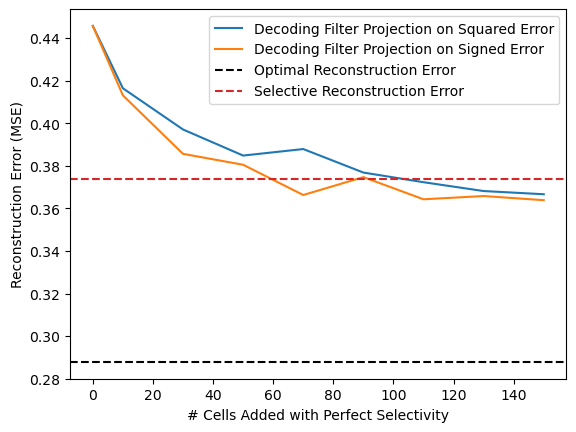

Target 11

30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims


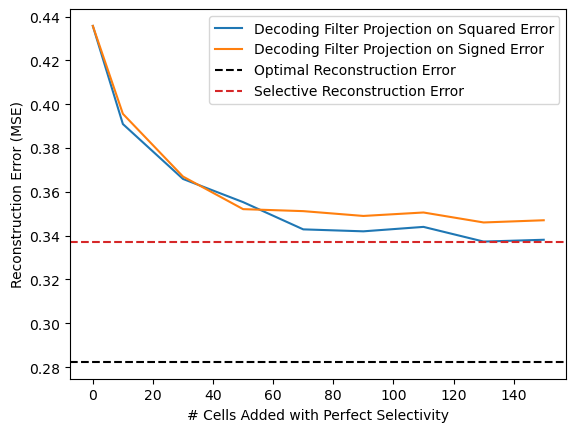

Target 12

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


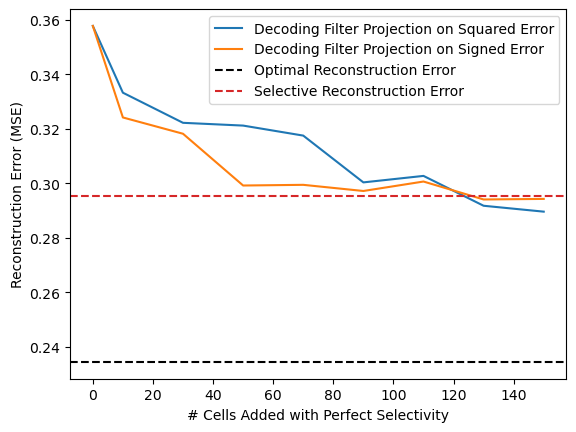

Target 13

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


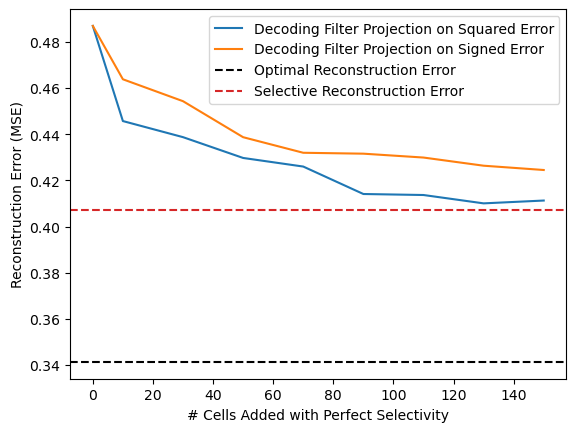

Target 14

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


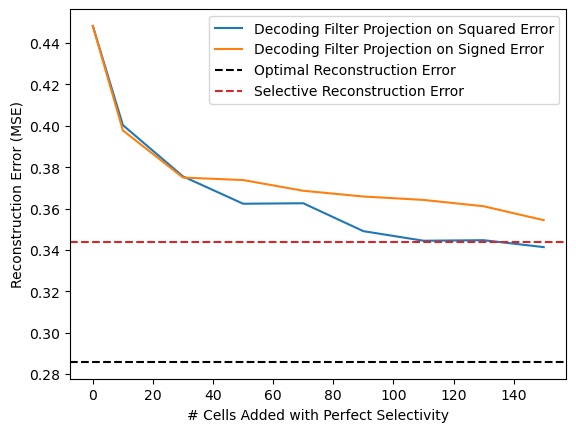

Target 15

30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


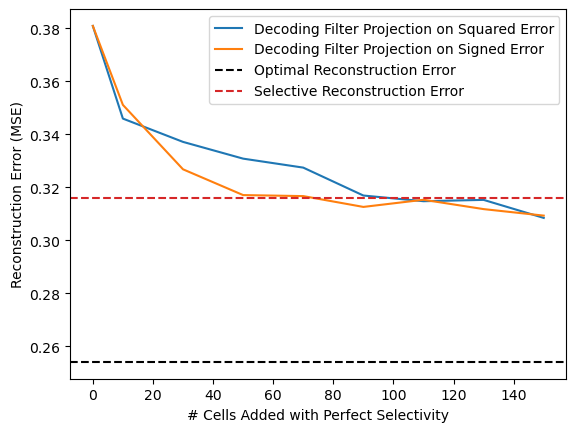

Target 16

30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


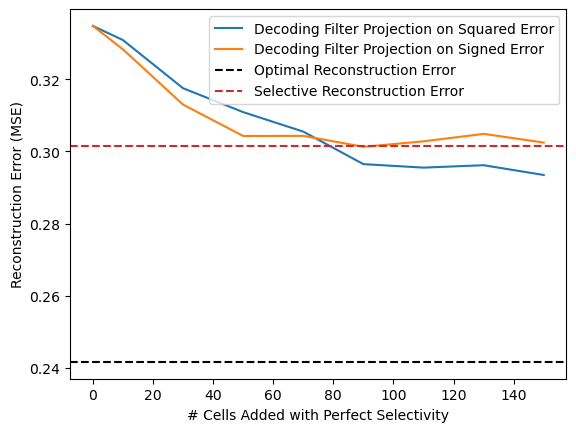

Target 17

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims


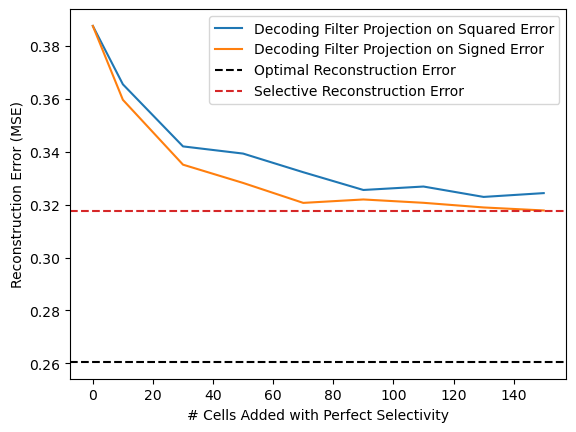

Target 18

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims


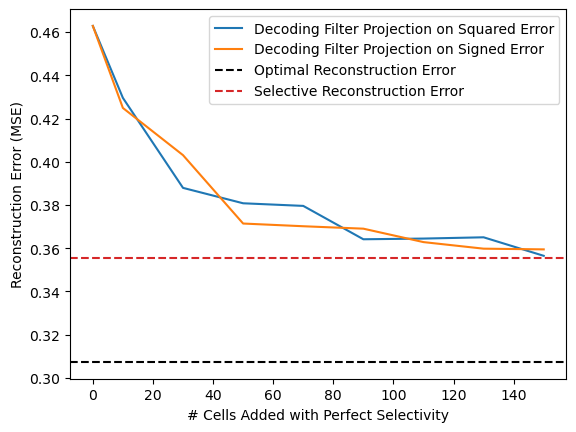

Target 19

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


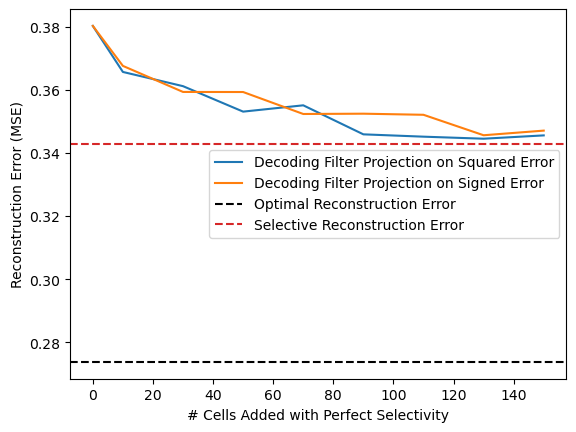

Target 20

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


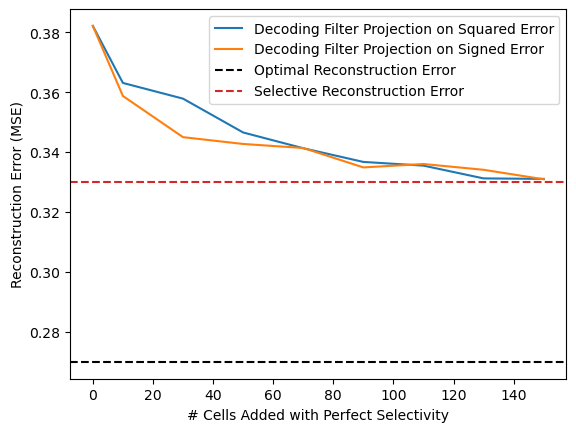

Target 21

30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims


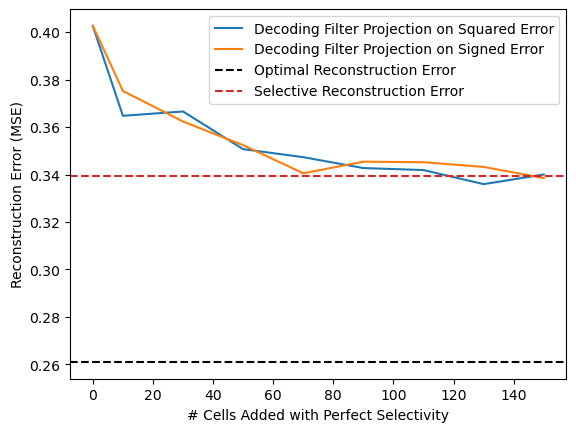

Target 22

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims


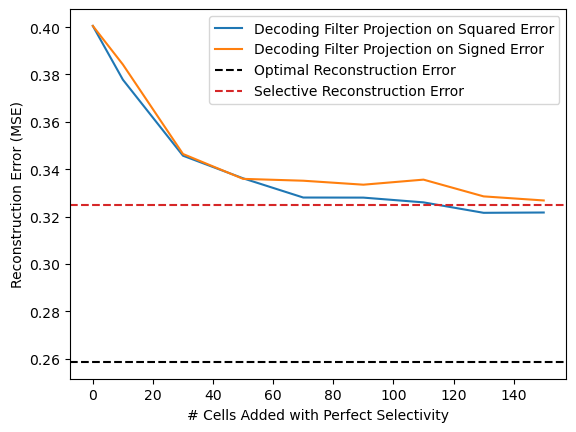

Target 23

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims63 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


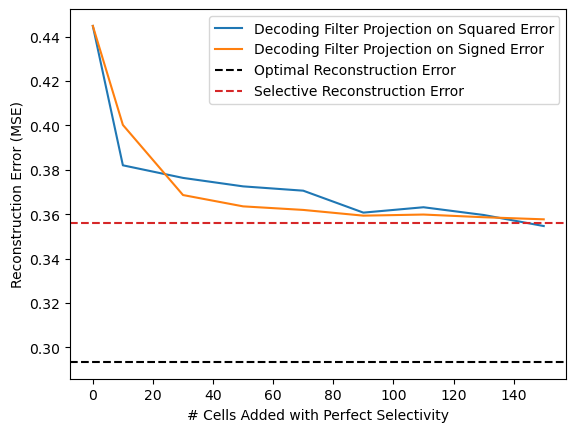

Target 24

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


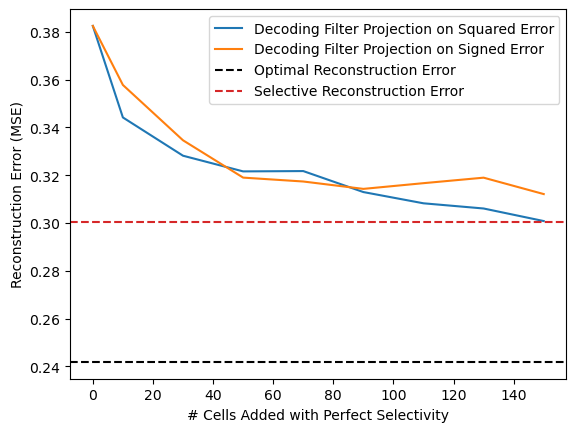

Target 25

30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsms
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims


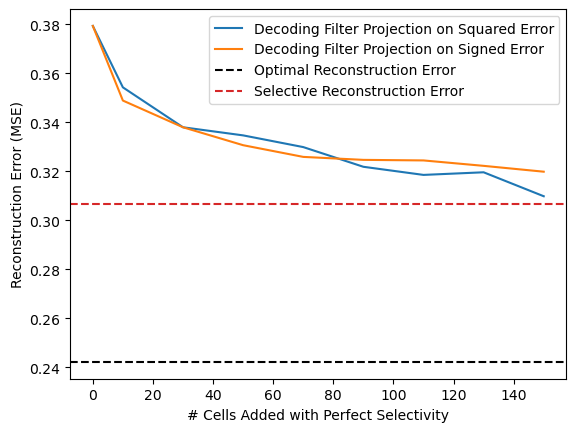

Target 26

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims


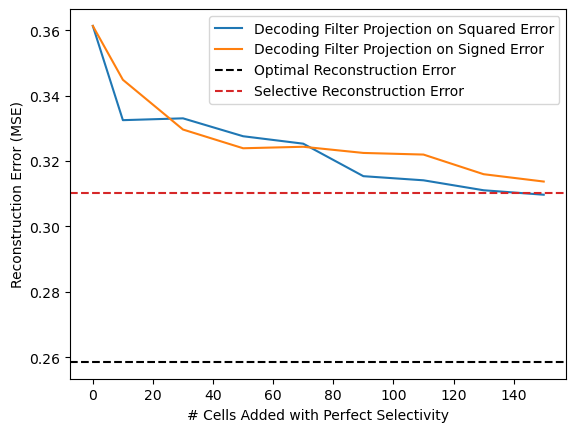

Target 27

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims


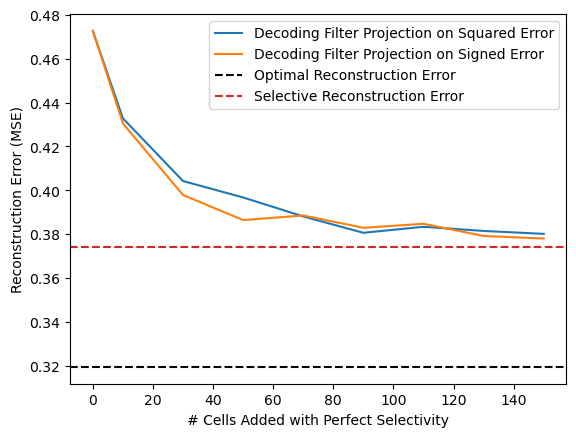

Target 28

30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


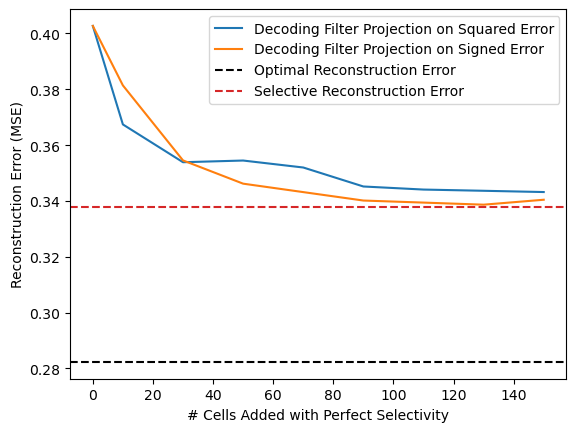

Target 29

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


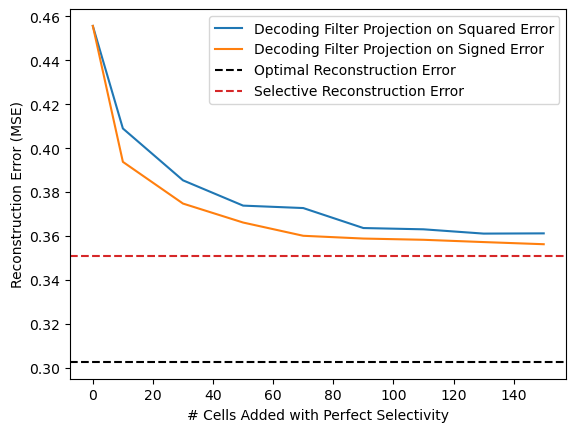

Target 30

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims


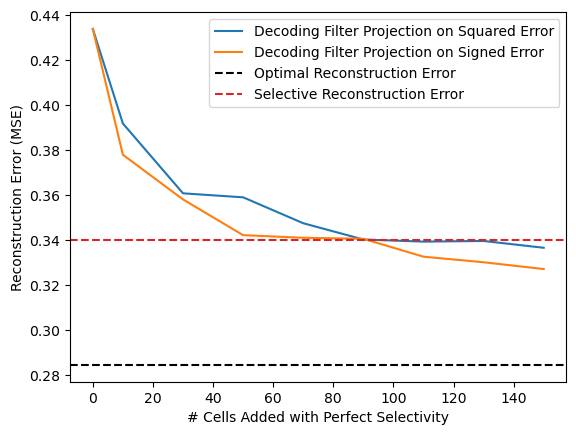

Target 31

30001 / 29999 Stims63 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


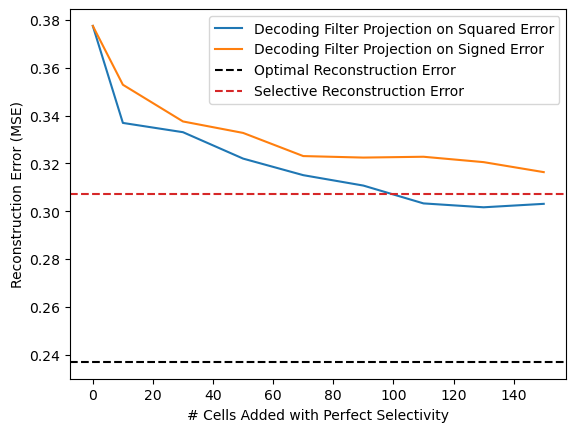

Target 32

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims


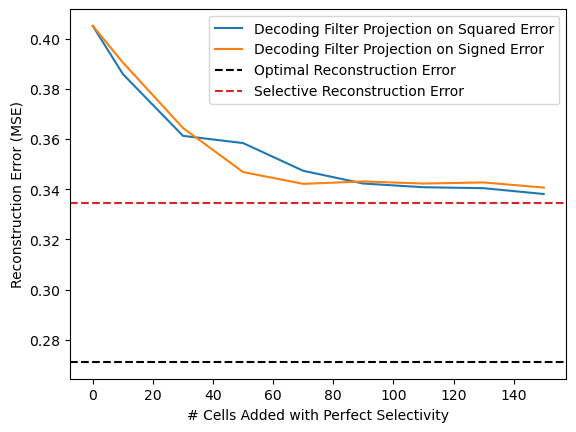

Target 33

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims


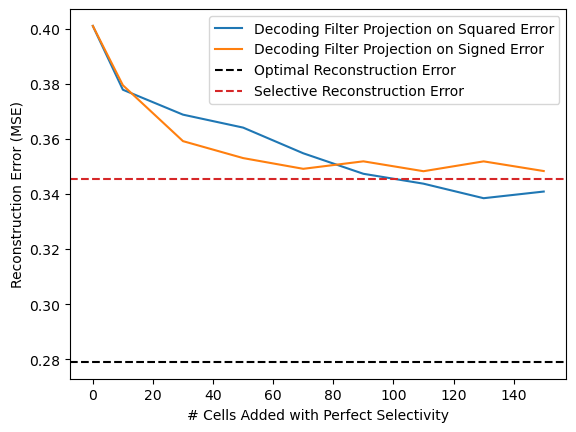

Target 34

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims


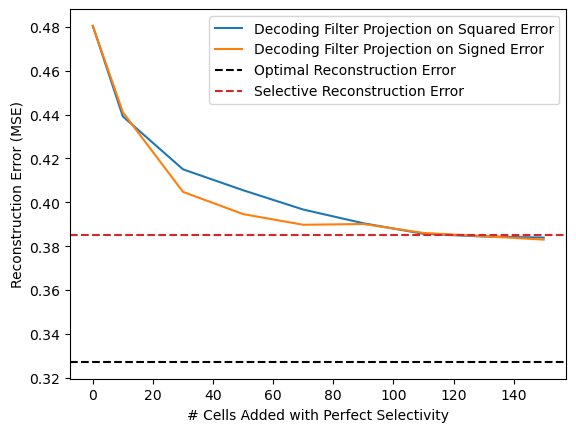

Target 35

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims


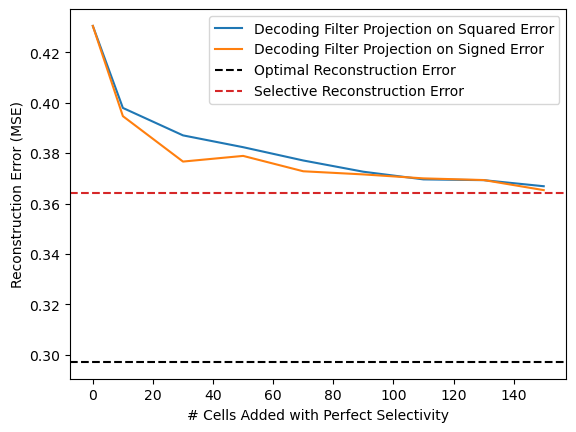

Target 36

30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


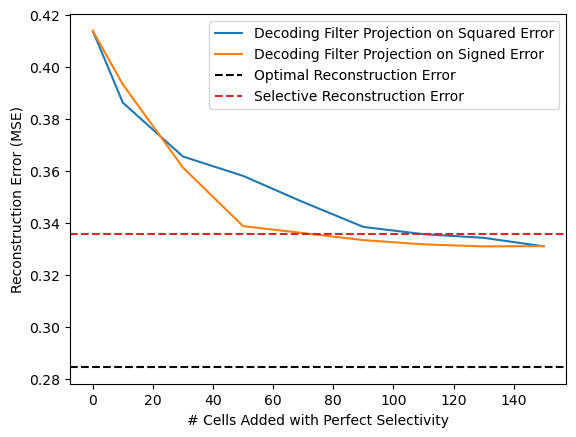

Target 37

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims


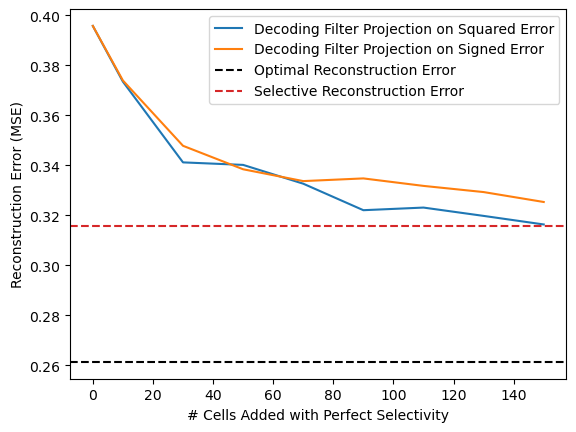

Target 38

30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


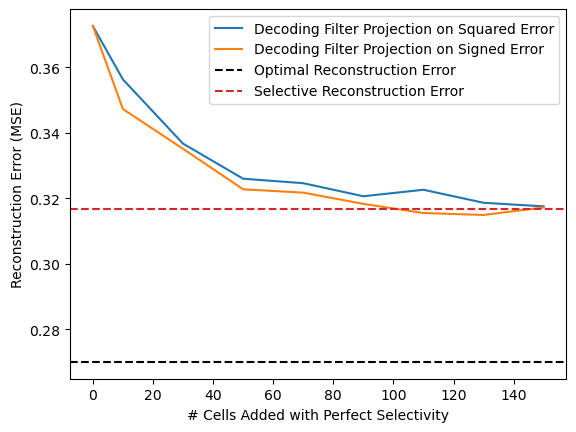

Target 39

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


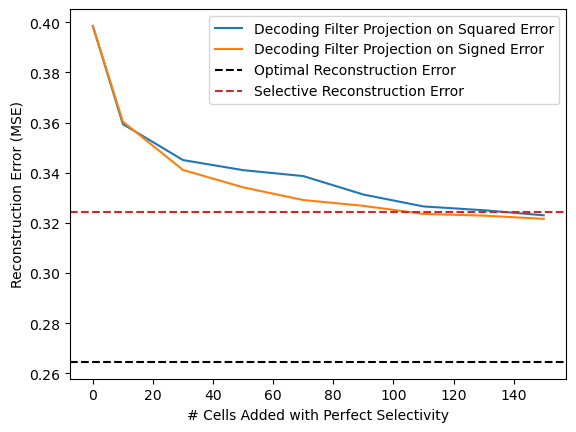

Target 40

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims


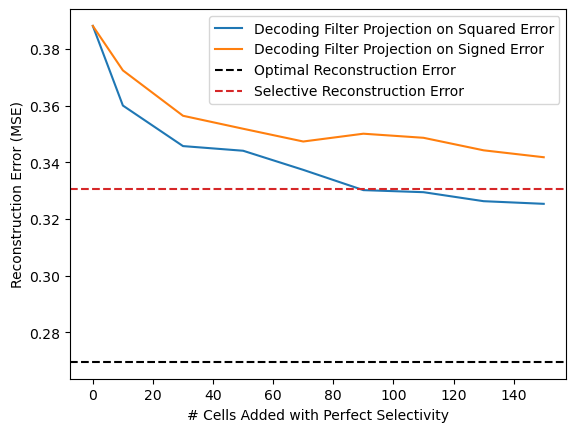

Target 41

30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims


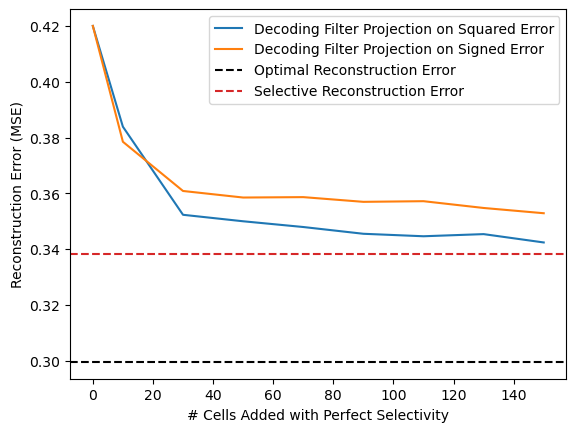

Target 42

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims


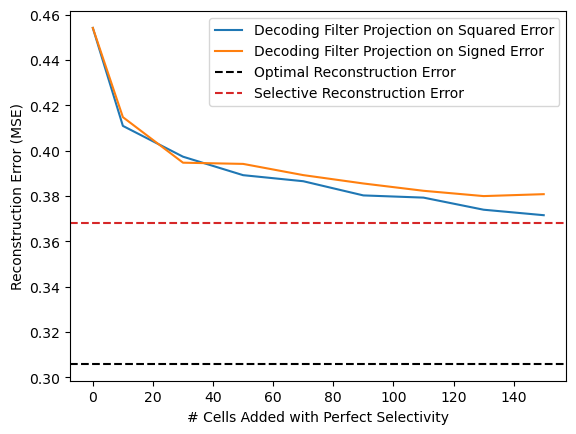

Target 43

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


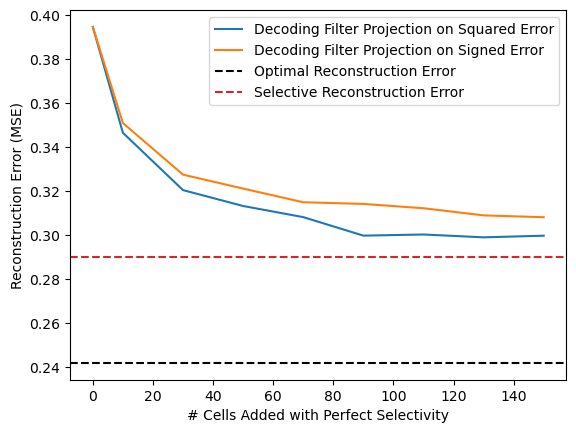

Target 44

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


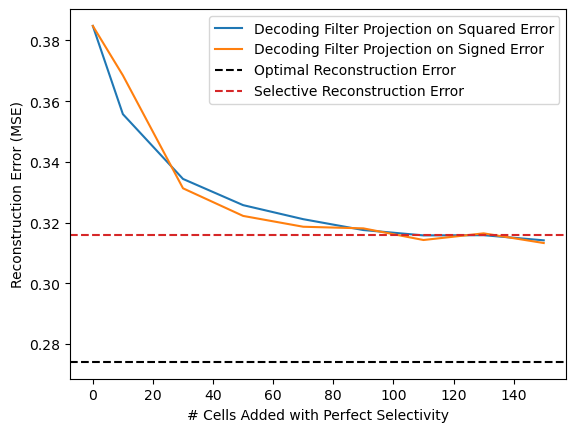

Target 45

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


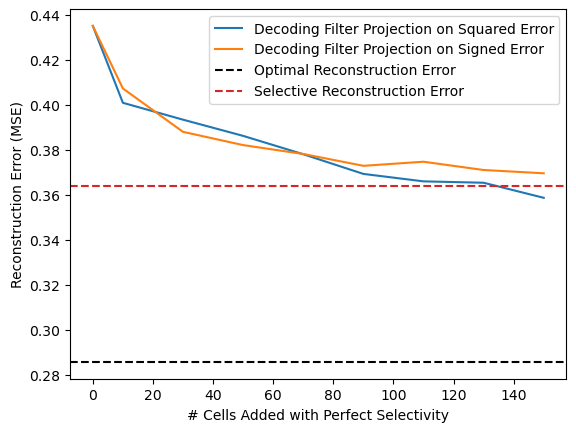

Target 46

30001 / 29999 Stims
30001 / 29999 Stims99 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


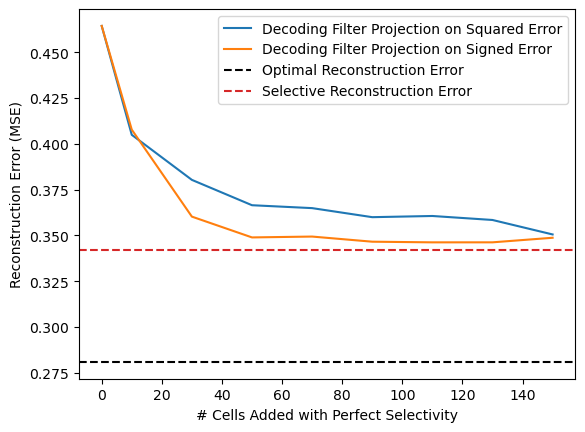

Target 47

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims


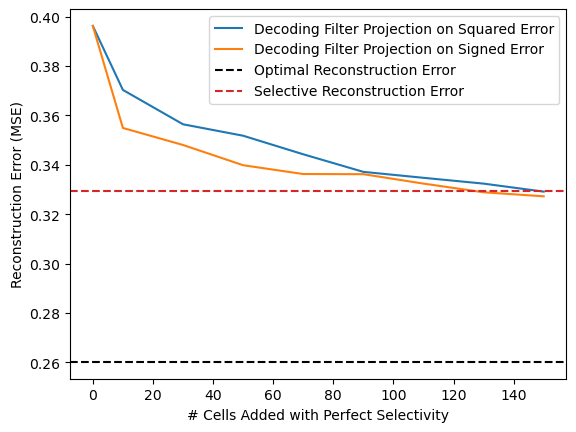

Target 48

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims


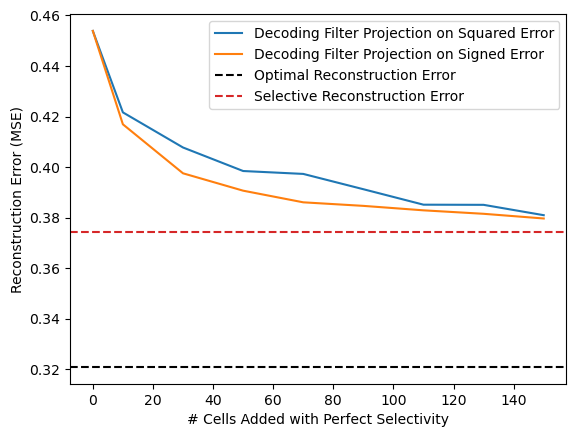

Target 49

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims


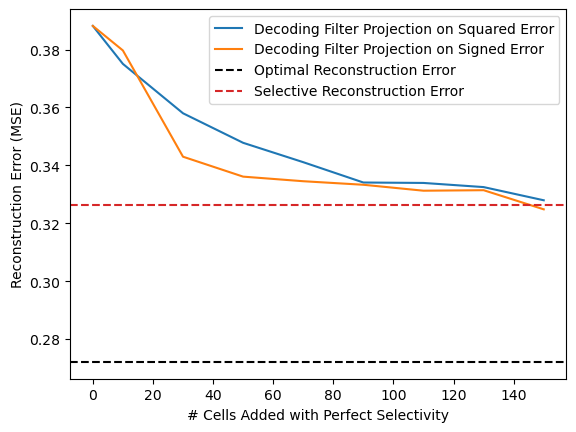

Target 50

30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims


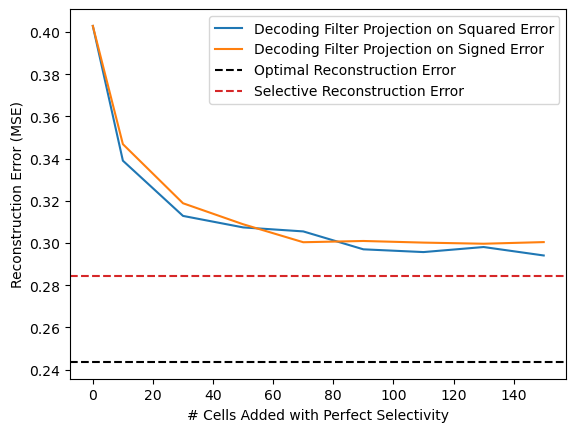

Target 51

30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


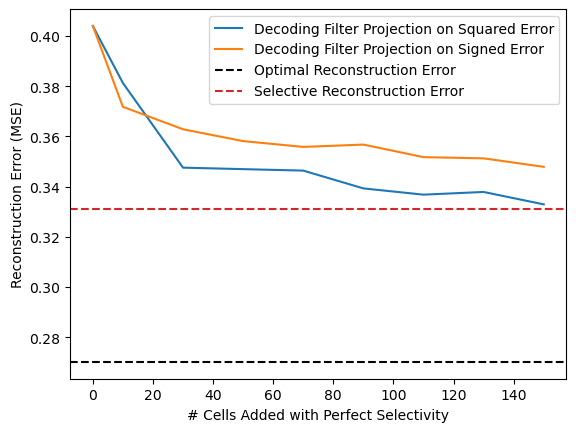

Target 52

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


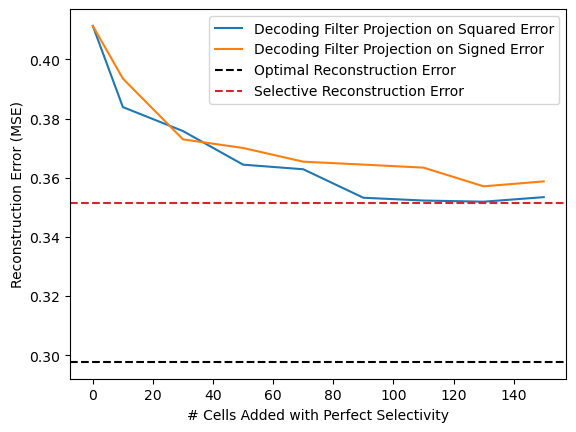

Target 53

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims


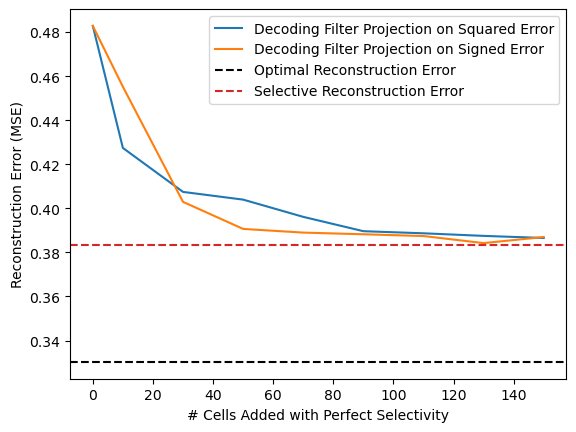

Target 54

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims


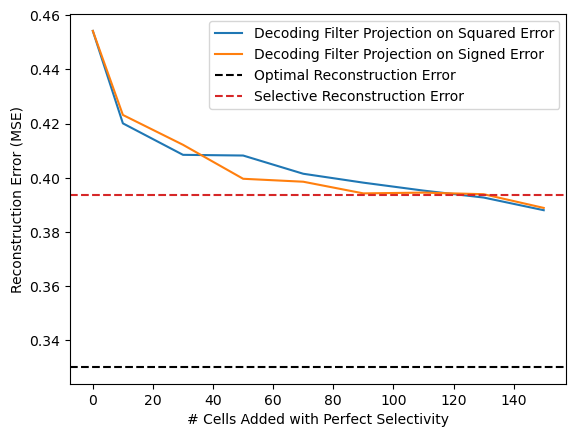

Target 55

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


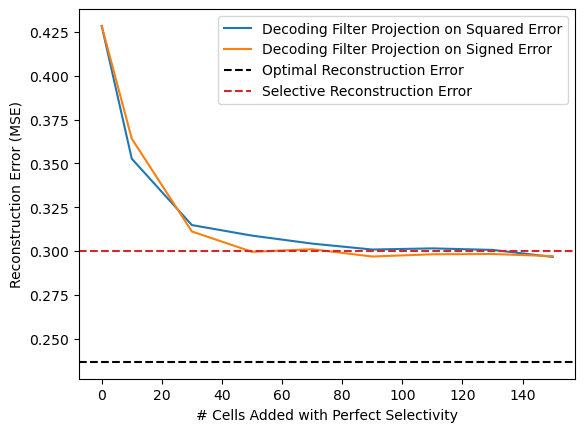

Target 56

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims


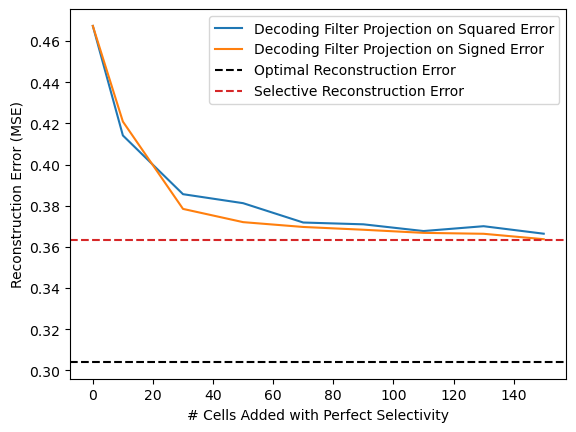

Target 57

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims


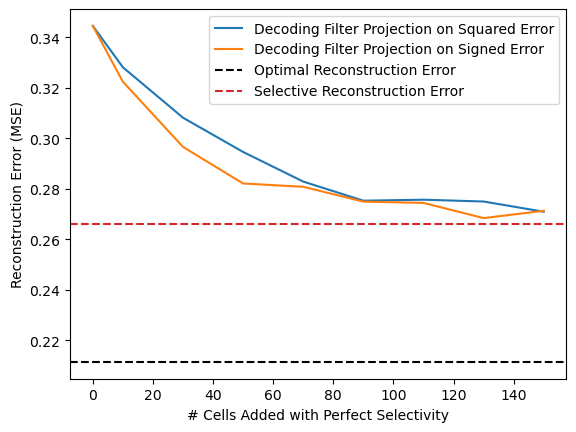

Target 58

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsms
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims


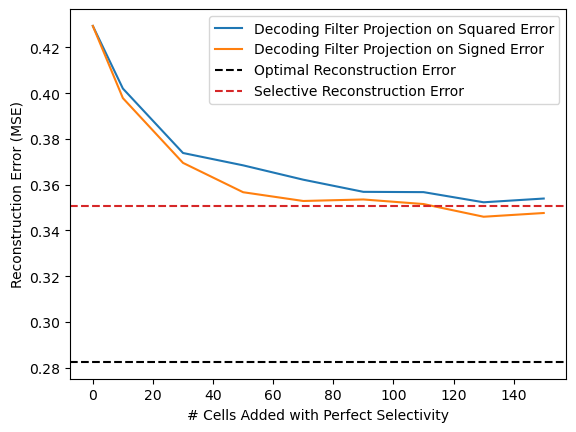

Target 59

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims


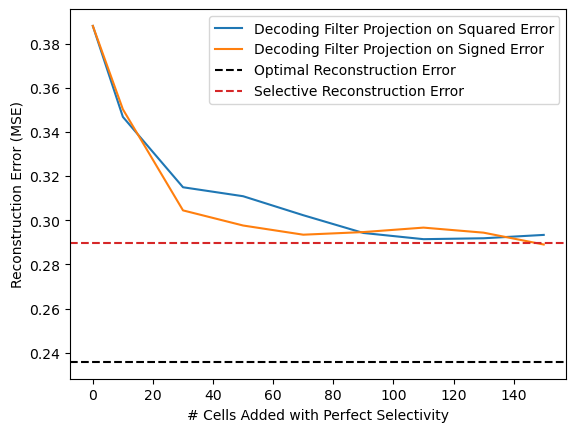

Target 60

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims


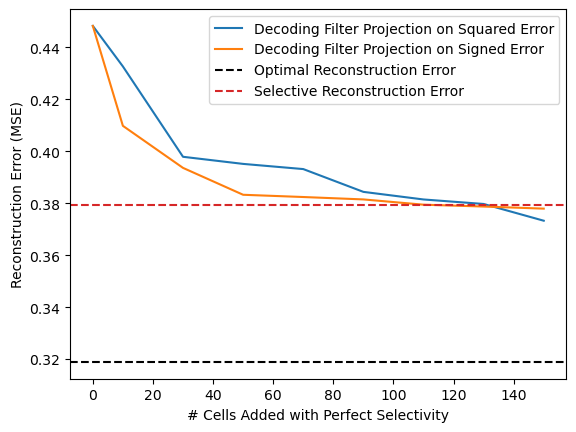

Target 61

30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims


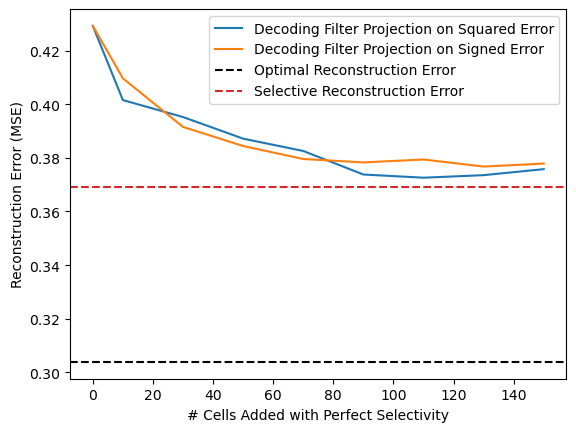

Target 62

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims


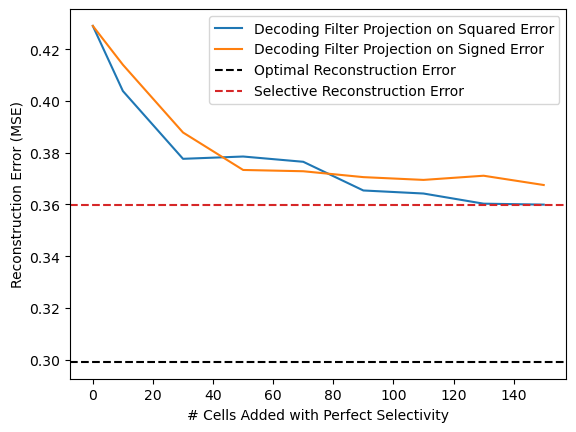

Target 63

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims


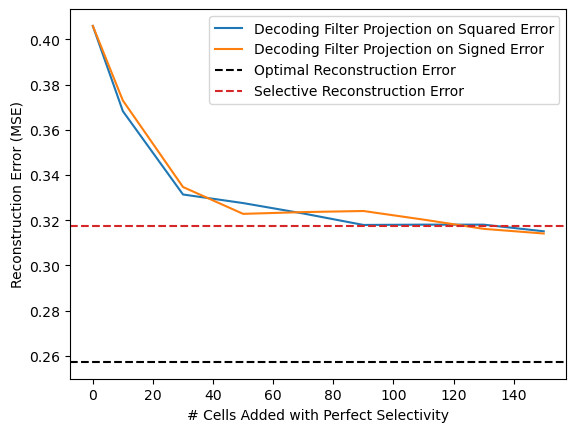

Target 64

30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


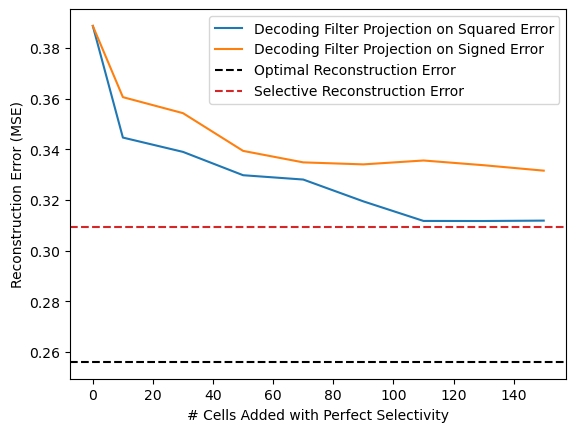

Target 65

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims


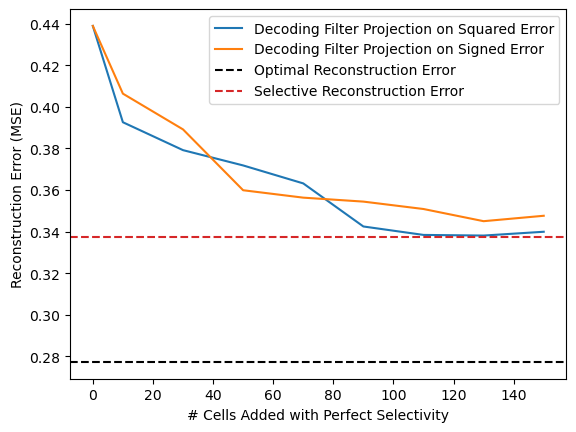

Target 66

30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


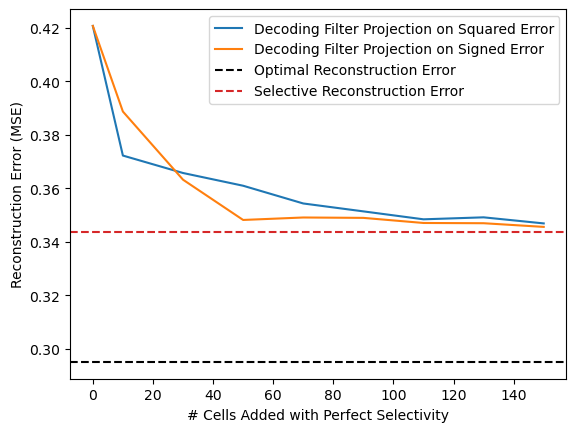

Target 67

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


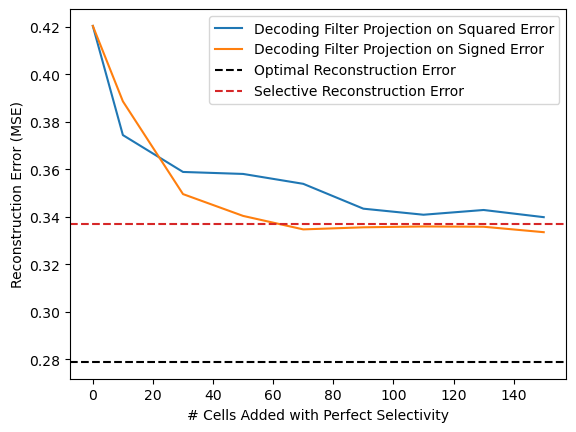

Target 68

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


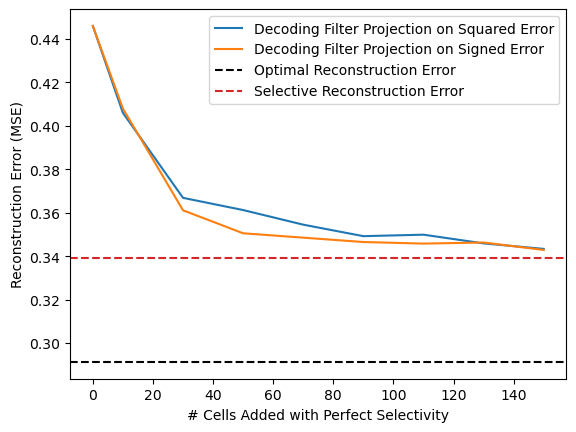

Target 69

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims


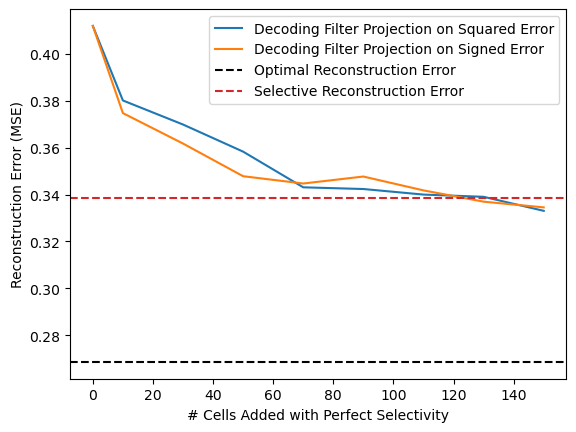

Target 70

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims29999 Stims
30001 / 29999 Stims/ 29999 Stims


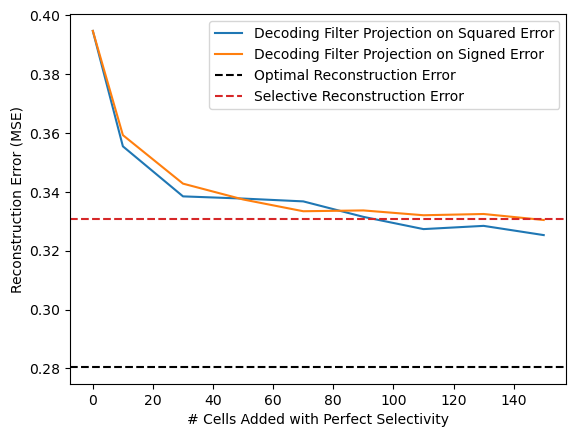

Target 71

30001 / 29999 Stims9 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


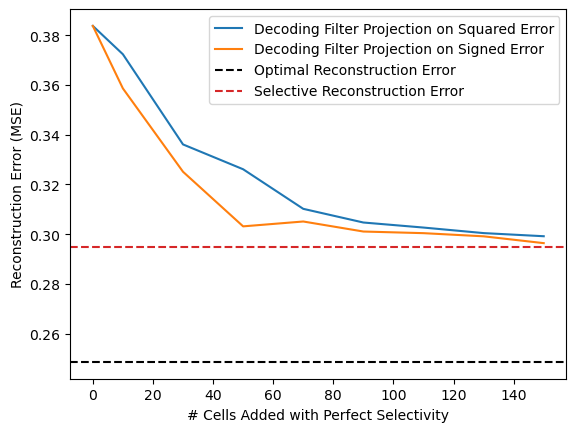

Target 72

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


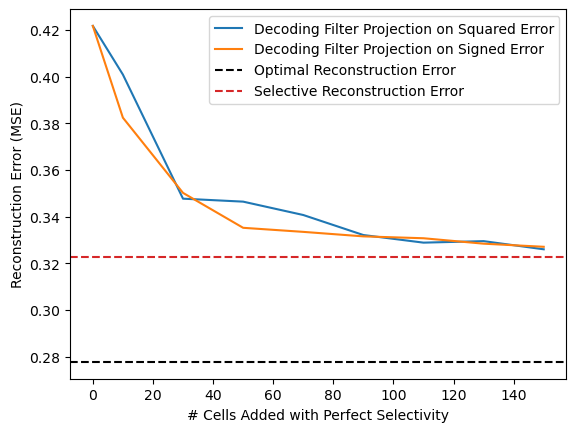

Target 73

30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims


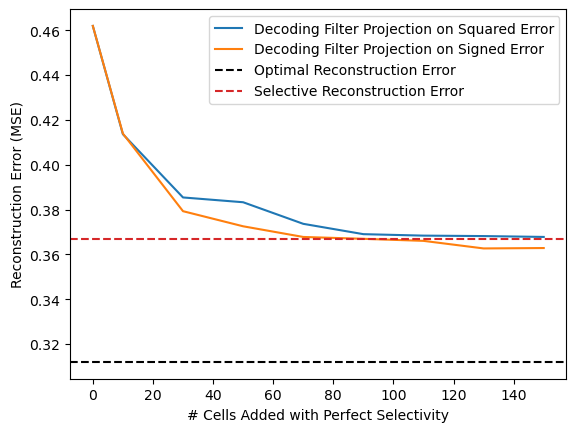

Target 74

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims99 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims


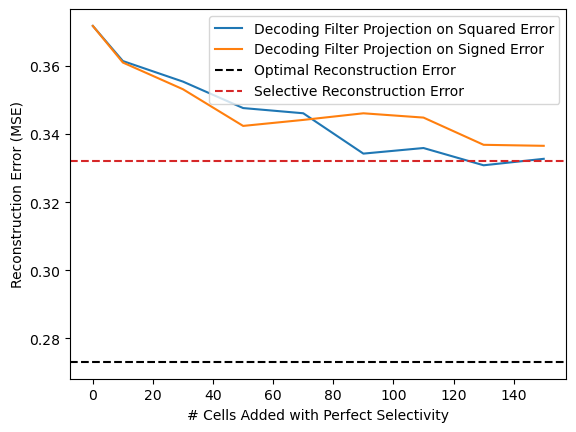

Target 75

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


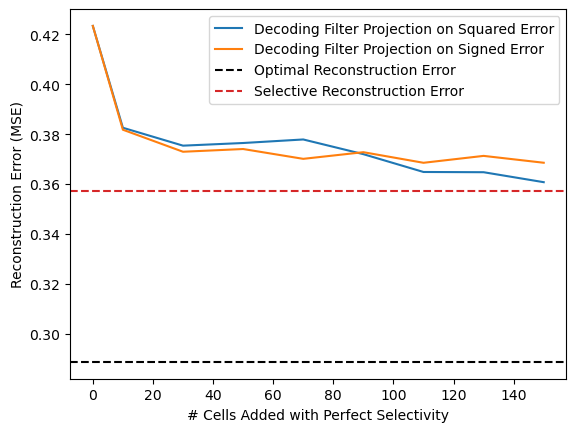

Target 76

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims


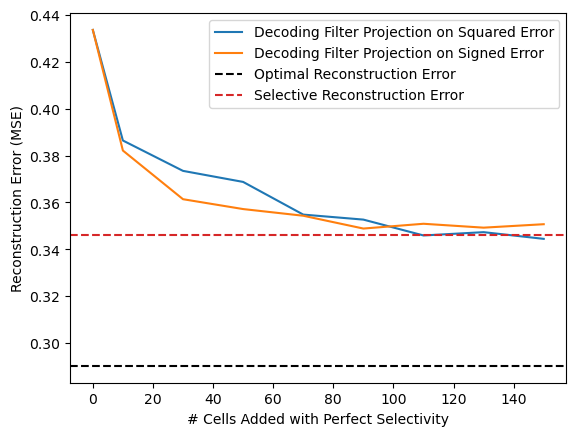

Target 77

30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


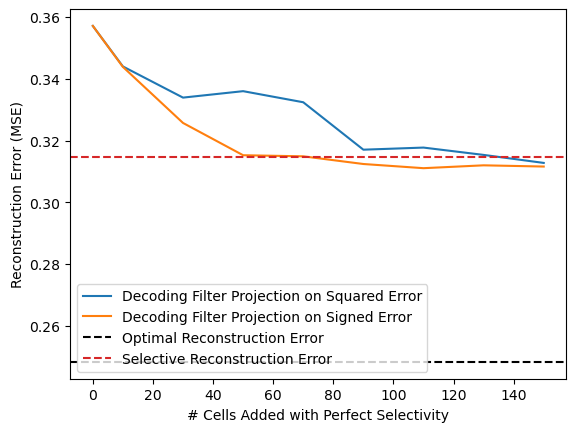

Target 78

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims


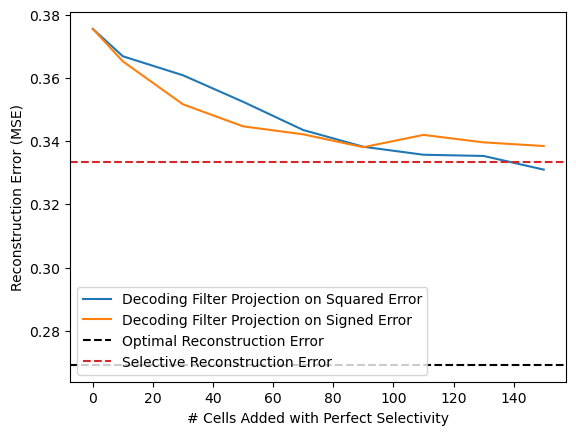

Target 79

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims


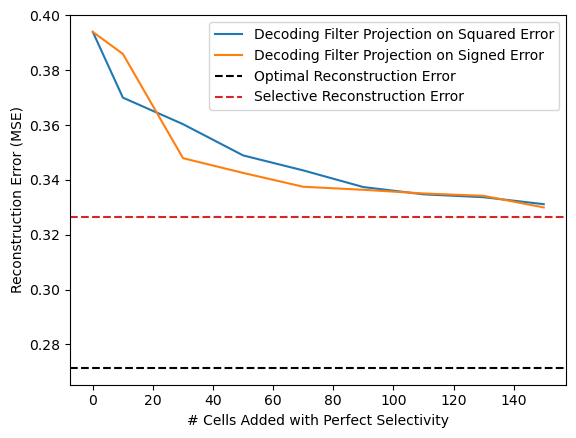

Target 80

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stimss
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims


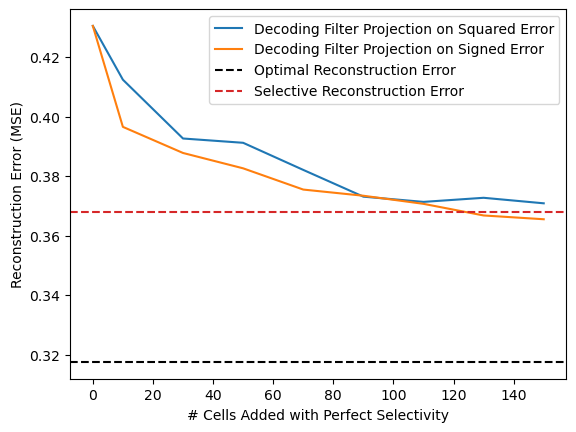

Target 81

30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims


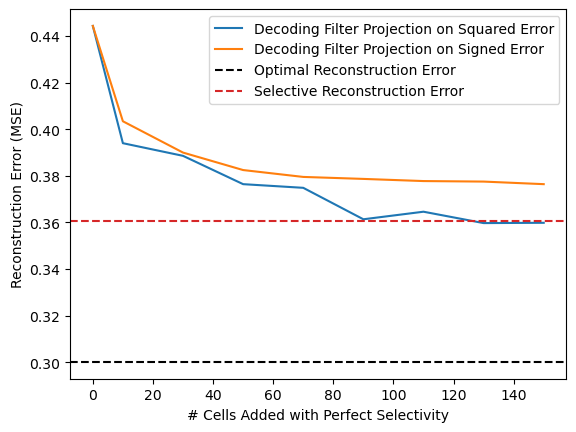

Target 82

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


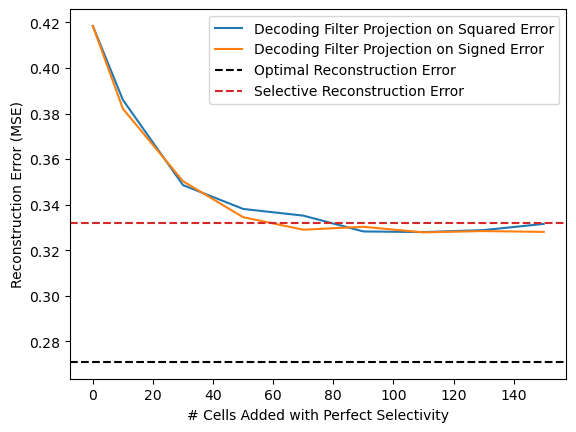

Target 83

30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


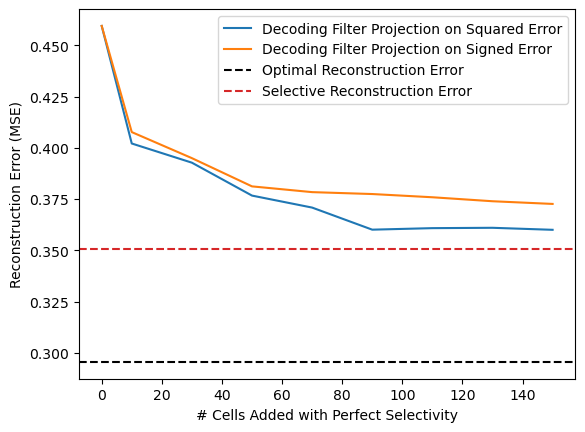

Target 84

30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimss
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims


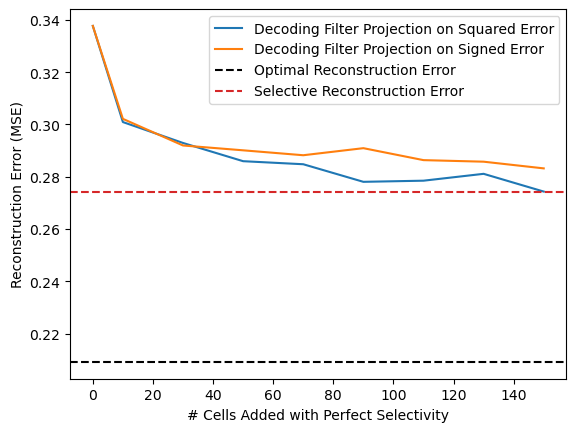

Target 85

30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims


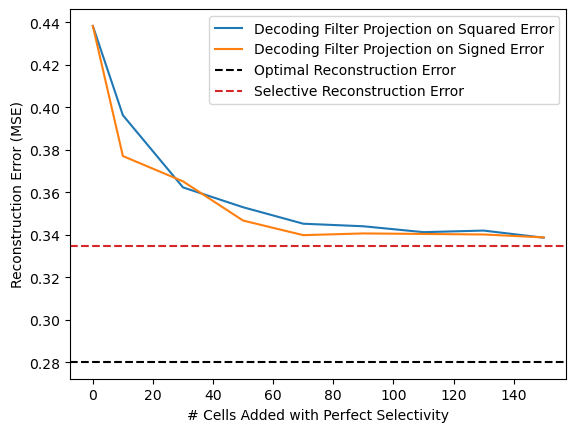

Target 86

30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims


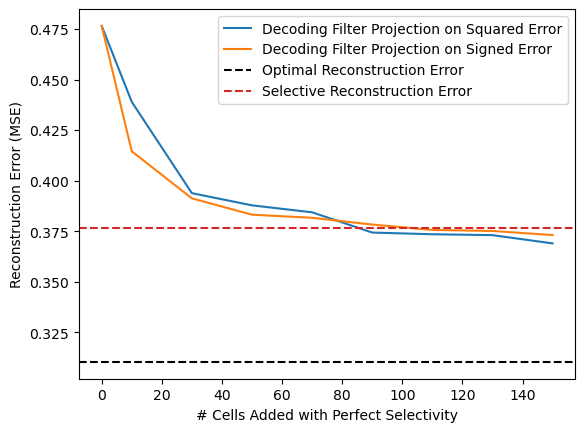

Target 87

30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


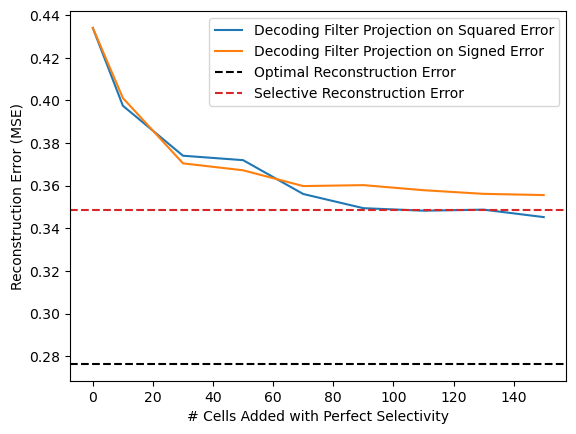

Target 88

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims


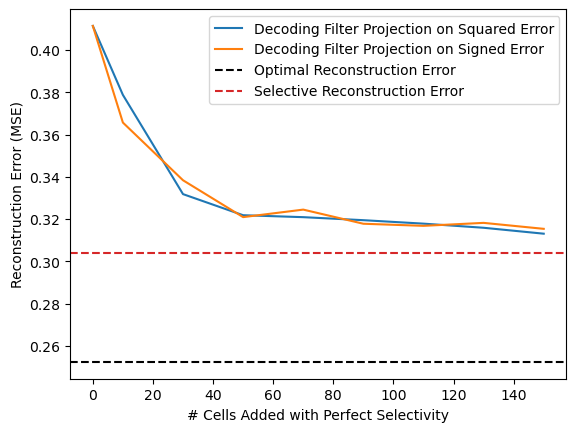

Target 89

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims 29999 Stims
30001 / 29999 StimsStims


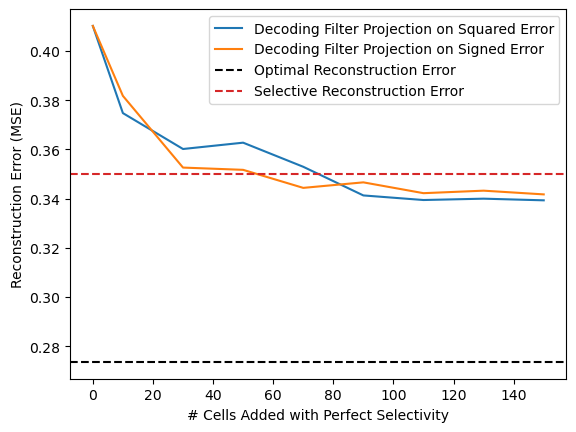

Target 90

30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


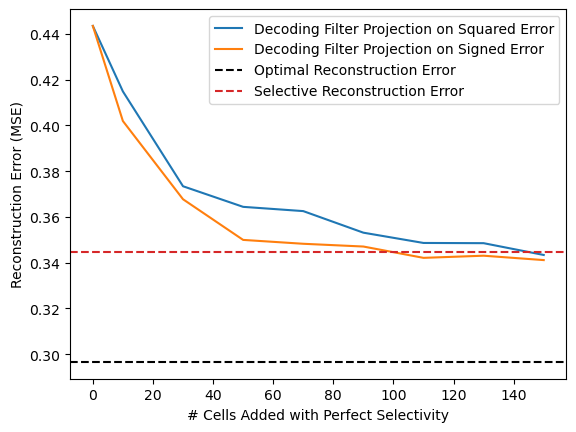

Target 91

30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims


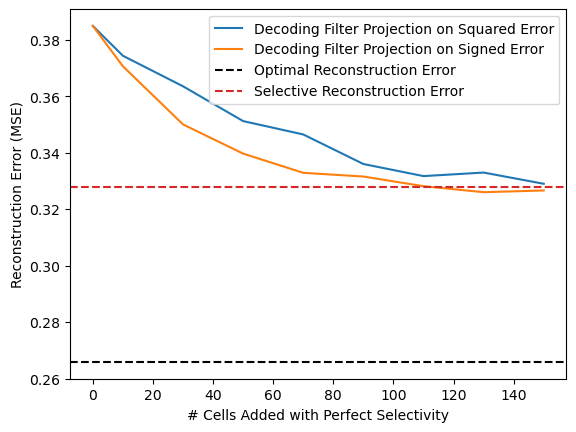

Target 92

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims


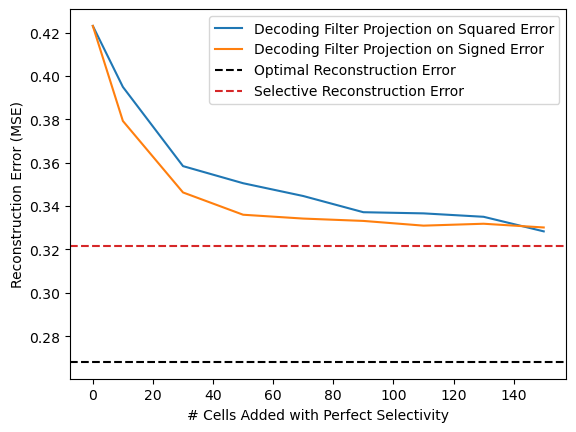

Target 93

30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


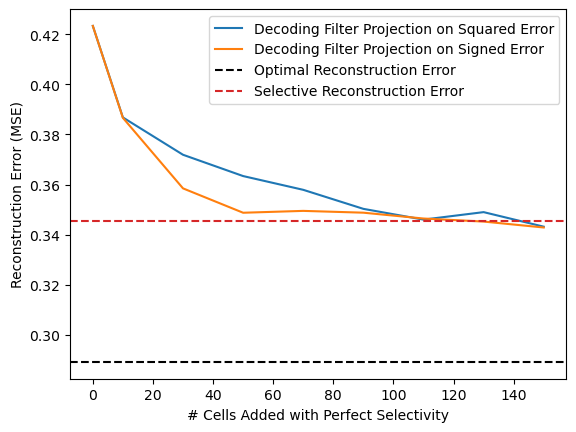

Target 94

30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


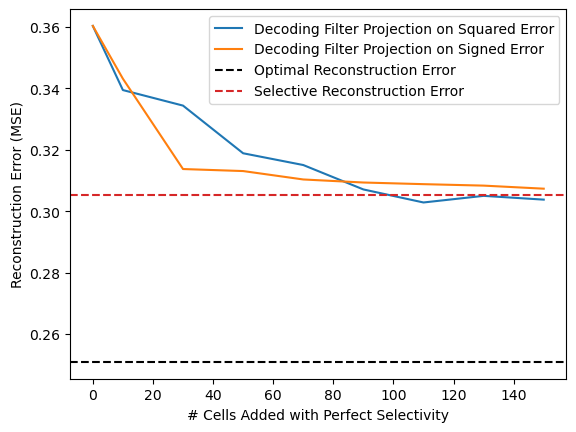

Target 95

30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims


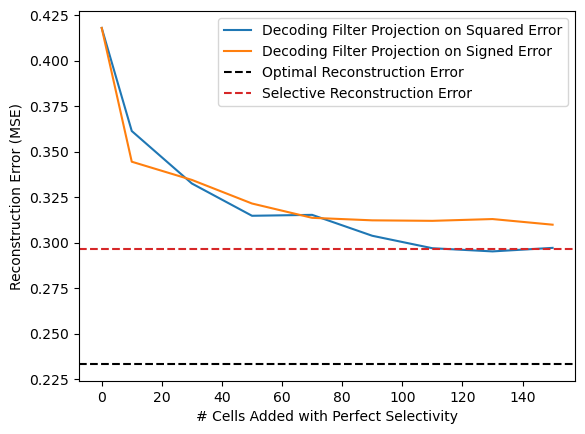

Target 96

30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


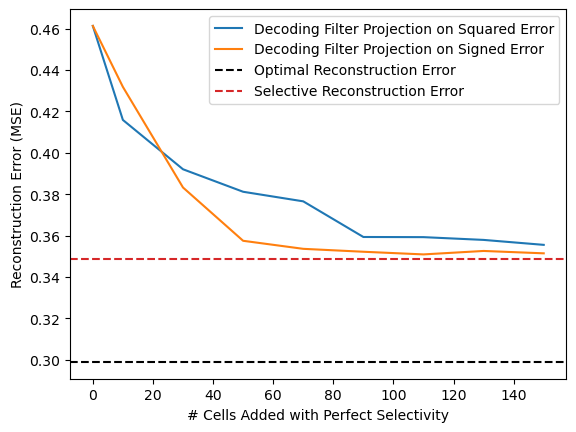

Target 97

30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims


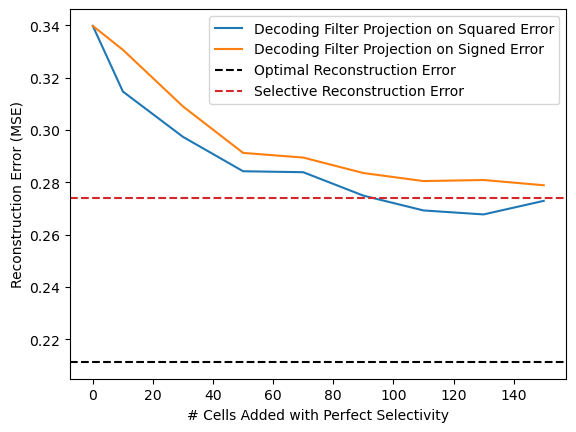

Target 98

30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims


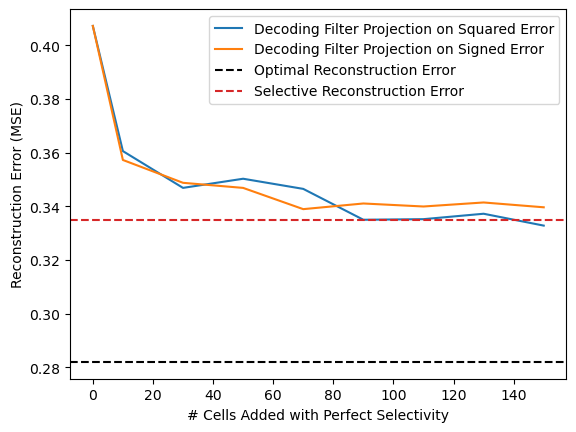

Target 99

30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims


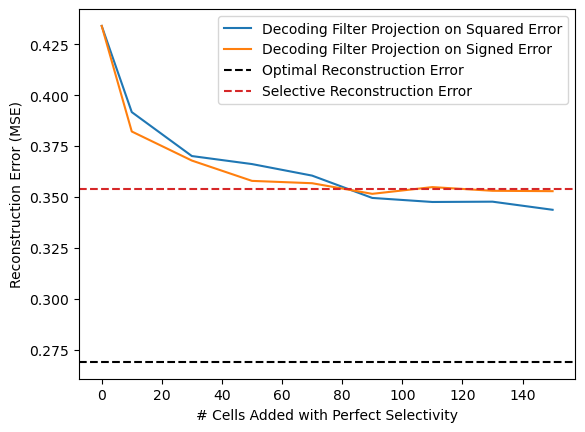

Target 100

30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 StimsStims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stimsims
30001 / 29999 Stims
30001 / 29999 StimsStims
30001 / 29999 Stims29999 Stims
30001 / 29999 Stims/ 29999 Stims
30001 / 29999 Stims
30001 / 29999 StimsStims


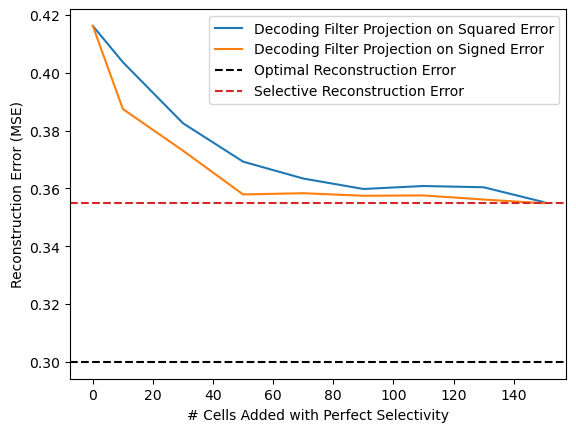

In [19]:
NUM_TARGETS = 100
error_list_all = []
error_list_signed_all = []
base_err_all = []
opt_err_all = []
sel_err_all = []

for target in range(NUM_TARGETS):
    print(f'Target {target+1}')
    
    visual_stimulus = recon.get_random_stimuli_jitter(1, 32, RESAMPLE_X, RESAMPLE_Y)
    visual_stimulus = visual_stimulus.reshape(1, 160, 320)

    # plt.figure()
    # plt.imshow(visual_stimulus[0] * mask.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    experiment_without_sm = GTDExperiment(
        dictionary=dictionary_matrix, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay = REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time = GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm = experiment_without_sm.run()
    masked_expt = experiment_without_sm.reconstruction[0].flatten() * mask

    # plt.figure()
    # plt.imshow(masked_expt.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    masked_stimulus = jnp.array(visual_stimulus[0].reshape(160*320, 1).ravel() * mask)
    masked_decoder = jnp.array((decoding_filters.T * mask[:, None]))

    losses, x = recon.get_optimal_recon_jax(masked_decoder, masked_stimulus, 
                                            jnp.array(np.absolute(np.random.normal(size=decoding_filters.shape[0]))),
                                            step_size=2, n_steps=1000, verbose=False, obj_tol=1e-5)

    # plt.figure()
    # plt.plot(losses)
    # plt.show()

    masked_opt = (decoding_filters.T @ x) * mask
    # plt.figure()
    # plt.imshow(masked_opt.reshape(160,320),cmap='gray', vmin=-1, vmax=1)
    # plt.xlim([70,250])
    # plt.show()

    cell_products = np.zeros(decoding_filters.shape[0])
    for i in range(decoding_filters.shape[0]):
        # plt.figure()
        # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
        # plt.show()

        pixel_mask = (encoding_filters[i, :] != 0).astype(int)

        # plt.figure()
        # plt.imshow((decoding_filters[i, :] * pixel_mask).reshape(160, 320), cmap='gray')
        # plt.show()

        cell_products[i] = ((decoding_filters[i, :] * pixel_mask)**2 @ error_map_avg / 
                            (np.linalg.norm(error_map_avg) * np.linalg.norm((decoding_filters[i, :] * pixel_mask)**2)))
        
    error_list = []
    num_cells_list = [10, 30, 50, 70, 90, 110, 130, 150]
    # num_cells_with_high_sel = []
    # sel_thresh = 0.95
    # num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix.T) > sel_thresh))

    for j in range(len(num_cells_list)):
        num_cells = num_cells_list[j]
        bad_cell_inds = np.flip(np.argsort(cell_products))[:num_cells]
        # print(bad_cell_inds)

        bad_superimposed = np.zeros(encoding_filters.shape[1])
        for i in bad_cell_inds:
            bad_superimposed += encoding_filters[i, :]

        # plt.figure()
        # plt.imshow(bad_superimposed.reshape(160, 320), cmap='gray')
        # plt.show()

        augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[1]))
        augmented_EA = np.zeros((len(bad_cell_inds), 2))
        for i in range(len(bad_cell_inds)):
            augmented_entries[i, bad_cell_inds[i]] = 1
            augmented_EA[i, 0] = 519 + i
            augmented_EA[i, 1] = 30

        dictionary_matrix_aug = np.vstack((dictionary_matrix, augmented_entries))
        electrodes_amplitudes_aug = np.vstack((electrodes_amplitudes, augmented_EA))

        # num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix_aug.T) > sel_thresh))

        dictionary_info_aug = []
        for entry in range(dictionary_matrix_aug.shape[0]):
            dictionary_info_aug.append(
                DictionaryEntry(
                electrodes= [electrodes_amplitudes_aug[entry, 0]],
                pulses_indices=[electrodes_amplitudes_aug[entry, 1]],
                num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
                )
                )
            
        experiment_without_sm_aug = GTDExperiment(
            dictionary=dictionary_matrix_aug, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
            dictionary_info=dictionary_info_aug, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
            visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
            visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
            frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
            stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
            refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
            guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
            )

        print(flush=True)
        #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
        sef_array_no_sm_aug = experiment_without_sm_aug.run()
        masked_aug = experiment_without_sm_aug.reconstruction[0].flatten() * mask

        # plt.figure()
        # plt.imshow(masked_aug.reshape(160,320),cmap='gray')
        # plt.xlim([70,250])
        # plt.show()
        
        error_list.append(experiment_without_sm_aug.compute_reconstruction_mse())

    cell_products_signed = np.zeros(decoding_filters.shape[0])
    for i in range(decoding_filters.shape[0]):
        # plt.figure()
        # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
        # plt.show()

        pixel_mask = (encoding_filters[i, :] != 0).astype(int)

        # plt.figure()
        # plt.imshow((decoding_filters[i, :] * pixel_mask).reshape(160, 320), cmap='gray')
        # plt.show()

        cell_products_signed[i] = (decoding_filters[i, :] * pixel_mask) @ signed_error_map_avg 

    error_list_signed = []
    # num_cells_with_high_sel = []
    # sel_thresh = 0.95
    # num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix.T) > sel_thresh))

    for j in range(len(num_cells_list)):
        num_cells = num_cells_list[j]
        bad_cell_inds = np.flip(np.argsort(cell_products_signed))[:num_cells]
        # print(bad_cell_inds)

        bad_superimposed = np.zeros(encoding_filters.shape[1])
        for i in bad_cell_inds:
            bad_superimposed += encoding_filters[i, :]

        # plt.figure()
        # plt.imshow(bad_superimposed.reshape(160, 320), cmap='gray')
        # plt.show()

        augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[1]))
        augmented_EA = np.zeros((len(bad_cell_inds), 2))
        for i in range(len(bad_cell_inds)):
            augmented_entries[i, bad_cell_inds[i]] = 1
            augmented_EA[i, 0] = 519 + i
            augmented_EA[i, 1] = 30

        dictionary_matrix_aug = np.vstack((dictionary_matrix, augmented_entries))
        electrodes_amplitudes_aug = np.vstack((electrodes_amplitudes, augmented_EA))

        # num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix_aug.T) > sel_thresh))

        dictionary_info_aug = []
        for entry in range(dictionary_matrix_aug.shape[0]):
            dictionary_info_aug.append(
                DictionaryEntry(
                electrodes= [electrodes_amplitudes_aug[entry, 0]],
                pulses_indices=[electrodes_amplitudes_aug[entry, 1]],
                num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
                )
                )
            
        experiment_without_sm_aug = GTDExperiment(
            dictionary=dictionary_matrix_aug, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
            dictionary_info=dictionary_info_aug, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
            visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
            visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
            frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
            stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
            refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
            guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
            )

        print(flush=True)
        #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
        sef_array_no_sm_aug = experiment_without_sm_aug.run()
        masked_aug = experiment_without_sm_aug.reconstruction[0].flatten() * mask

        # plt.figure()
        # plt.imshow(masked_aug.reshape(160,320),cmap='gray')
        # plt.xlim([70,250])
        # plt.show()
        
        error_list_signed.append(experiment_without_sm_aug.compute_reconstruction_mse())
    
    dictionary_matrix_sel = np.eye(len(gsorted_cells))

    electrodes_amplitudes_sel = np.zeros((len(dictionary_matrix_sel), 2))
    for i in range(len(dictionary_matrix_sel)):
        electrodes_amplitudes_sel[i, 0] = 519 + i
        electrodes_amplitudes_sel[i, 1] = 30

    dictionary_info_sel = []
    for entry in range(dictionary_matrix_sel.shape[0]):
        dictionary_info_sel.append(
            DictionaryEntry(
            electrodes= [electrodes_amplitudes_sel[entry, 0]],
            pulses_indices=[electrodes_amplitudes_sel[entry, 1]],
            num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
            )
            )

    experiment_without_sm_sel = GTDExperiment(
        dictionary=dictionary_matrix_sel, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info_sel, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm_sel = experiment_without_sm_sel.run()
    masked_sel = experiment_without_sm_sel.reconstruction[0].flatten() * mask

    # plt.figure()
    # plt.imshow(masked_sel.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    base_err = experiment_without_sm.compute_reconstruction_mse()
    opt_err = recon.n_mse(visual_stimulus.flatten()[..., None], 
                        masked_opt[..., None], sig_stix)
    sel_err = experiment_without_sm_sel.compute_reconstruction_mse()

    plt.figure()
    plt.plot([0] + num_cells_list, [base_err] + error_list,
            label='Decoding Filter Projection on Squared Error')
    plt.plot([0] + num_cells_list, [base_err] + error_list_signed,
            label='Decoding Filter Projection on Signed Error')
    plt.axhline(opt_err, linestyle='--', c='k', label='Optimal Reconstruction Error')
    plt.axhline(sel_err, linestyle='--', c='tab:red', label='Selective Reconstruction Error')
    plt.xlabel('# Cells Added with Perfect Selectivity')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.legend()
    plt.show()

    error_list_all.append([base_err] + error_list)
    error_list_signed_all.append([base_err] + error_list_signed)
    base_err_all.append(base_err)
    opt_err_all.append(opt_err)
    sel_err_all.append(sel_err)

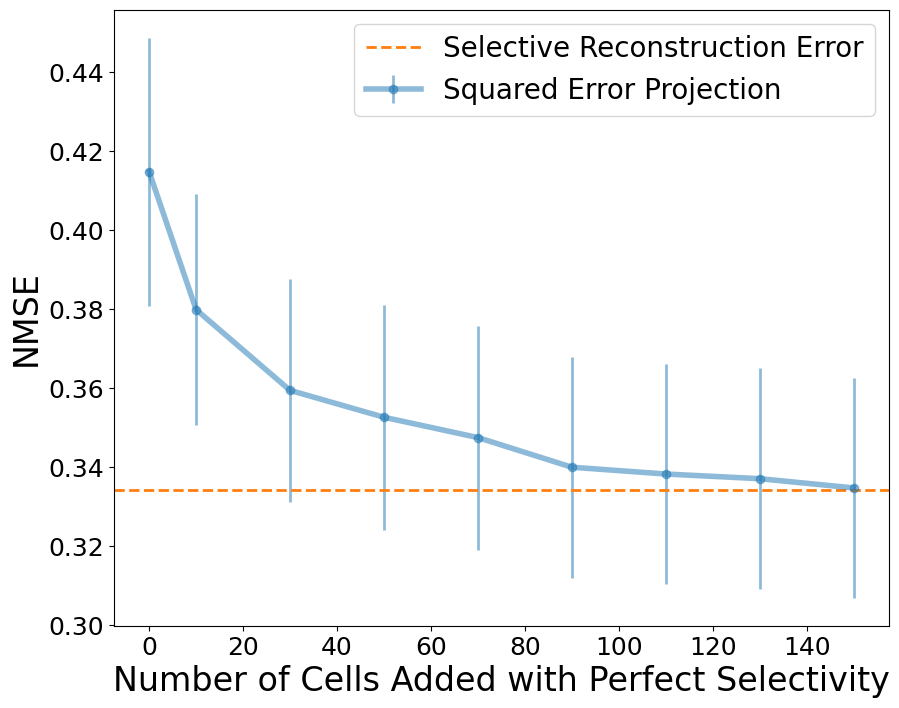

In [20]:
plt.figure(figsize=(10, 8))
plt.errorbar(np.array([0] + num_cells_list), np.mean(np.array(error_list_all), 0), 
             yerr=np.std(np.array(error_list_all), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Squared Error Projection', c='tab:blue', alpha=0.5)
# plt.errorbar([0] + num_cells_list, np.mean(np.array(error_list_signed_all), 0), 
#              yerr=np.std(np.array(error_list_signed_all), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Signed Error Projection', c='tab:orange', alpha=0.3)

plt.axhline(np.mean(sel_err_all), linestyle='--', c='tab:orange', linewidth=2, label='Selective Reconstruction Error')
# plt.axhline(np.mean(opt_err_all), linestyle='--', c='k', linewidth=2, label='Optimal Reconstruction Error')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Cells Added with Perfect Selectivity', fontsize=24)
plt.ylabel(r'NMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)

plt.savefig(f'greedy_augmented_r{NUM_TARGETS}_no-opt.png', dpi=300)

In [ ]:
def get_significant_electrodes(vcd, cell_no, thr_factor):
    cell_ei = vcd.get_ei_for_cell(cell_no).ei
    collapsed_ei = np.amin(cell_ei, axis=1)
    channel_noise = vcd.channel_noise
    significant_electrodes = np.argwhere(np.abs(collapsed_ei) > thr_factor * channel_noise).flatten()
    return significant_electrodes, np.abs(collapsed_ei)

In [ ]:
def split_cell_into_triplets(vcd: vl.VisionCellDataTable, cell_no: int, min_significant_electrodes: int, thr_factor: float,
                             verbose=False):
    good_inds, collapsed_ei = get_significant_electrodes(vcd, cell_no, thr_factor)
    significant_electrodes = good_inds + 1
    if verbose:
        print(significant_electrodes)
        
    if len(significant_electrodes) > 0:
        triplet_electrodes = np.array(triplet.TRIPLET_RECORD_ELECTRODES_519)
        num_elecs_per_triplet = np.count_nonzero(np.isin(triplet_electrodes, significant_electrodes).astype(int), axis=1)
        triplet_indices = np.where(num_elecs_per_triplet >= min_significant_electrodes)[0]
        
        if verbose:
            good_inds_plot, _ = get_significant_electrodes(vcd, cell_no, 1)
            coords = vcd.electrode_map
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.scatter(coords[:, 0], coords[:, 1], s=1, c="k")
            ax.scatter(coords[good_inds_plot, 0], coords[good_inds_plot, 1], s=collapsed_ei[good_inds_plot], c='tab:blue')
            plt.title(vcd.get_cell_type_for_cell(cell_no) + " " + str(cell_no), fontsize=22)

            for i, txt in enumerate(good_inds_plot):
                ax.annotate(txt+1, (coords[good_inds_plot[i], 0], coords[good_inds_plot[i], 1]), fontsize=6)
            for i, txt in enumerate(good_inds): 
                ax.annotate(txt+1, (coords[good_inds[i], 0], coords[good_inds[i], 1]), fontsize=6, color='r') 
                
            plt.show()

            print(len(triplet_indices))
            print(triplet.TRIPLET_RECORD_ELECTRODES_519[triplet_indices])
        
        return triplet_indices
    else:
        return np.array([])

In [ ]:
def get_triplets(vcd: vl.VisionCellDataTable, cell_list: list, n : int, min_significant_electrodes: int, thr_factor, verbose=False):
    total_triplet_indices = []
    for i in range(n):
        total_triplet_indices.append(split_cell_into_triplets(vcd, cell_list[i], min_significant_electrodes, thr_factor, verbose=verbose))
    return np.unique(np.concatenate(total_triplet_indices))

In [ ]:
all_triplets = get_triplets(vcd, cells_to_use[np.flip(np.argsort(cell_products))], 50, 2, 2, verbose=False)

In [ ]:
len(all_triplets)

In [ ]:
all_electrodes = np.unique(triplet.TRIPLET_RECORD_ELECTRODES_519[all_triplets].flatten())
electrode_inds = all_electrodes - 1
coords = vcd.electrode_map
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(coords[:, 0], coords[:, 1], s=1, c="k")

ax.scatter(coords[electrode_inds, 0], coords[electrode_inds, 1], c='tab:blue')
plt.title("All Electrodes In Triplets", fontsize=22)

for i, txt in enumerate(electrode_inds):
    ax.annotate(txt+1, (coords[electrode_inds[i], 0], coords[electrode_inds[i], 1]), fontsize=6)

plt.show()